In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open('../'+row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:53<00:00,  7.55s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

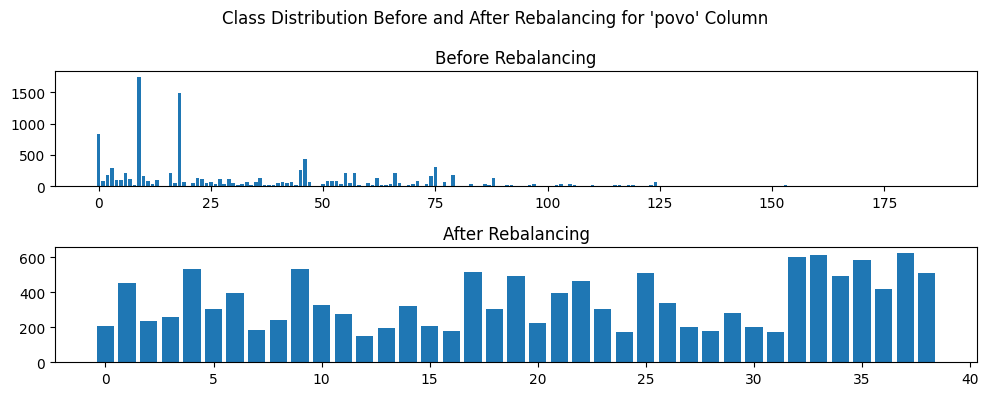

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:07<1:18:22, 247.51s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1108.5994, Validation Accuracy: 0.3300


Training model:  10%|████▌                                        | 2/20 [08:17<1:14:38, 248.80s/it]

Best model saved at epoch 2
Epoch 2, Loss: 810.5950, Validation Accuracy: 0.4522


Training model:  15%|██████▊                                      | 3/20 [12:25<1:10:26, 248.61s/it]

Best model saved at epoch 3
Epoch 3, Loss: 619.1959, Validation Accuracy: 0.5005


Training model:  20%|█████████                                    | 4/20 [16:30<1:05:53, 247.08s/it]

Best model saved at epoch 4
Epoch 4, Loss: 459.1991, Validation Accuracy: 0.5724


Training model:  25%|███████████▎                                 | 5/20 [20:36<1:01:40, 246.69s/it]

Best model saved at epoch 5
Epoch 5, Loss: 325.4594, Validation Accuracy: 0.6187


Training model:  30%|██████████████                                 | 6/20 [24:41<57:25, 246.11s/it]

Best model saved at epoch 6
Epoch 6, Loss: 221.8894, Validation Accuracy: 0.6345


Training model:  35%|████████████████▍                              | 7/20 [28:44<53:08, 245.24s/it]

Best model saved at epoch 7
Epoch 7, Loss: 147.2876, Validation Accuracy: 0.6443


Training model:  40%|██████████████████▊                            | 8/20 [32:45<48:46, 243.87s/it]

Best model saved at epoch 8
Epoch 8, Loss: 97.4886, Validation Accuracy: 0.6463


Training model:  45%|█████████████████████▏                         | 9/20 [36:47<44:33, 243.08s/it]

Best model saved at epoch 9
Epoch 9, Loss: 66.0475, Validation Accuracy: 0.6562


Training model:  50%|███████████████████████                       | 10/20 [40:47<40:23, 242.35s/it]

Best model saved at epoch 10
Epoch 10, Loss: 45.4052, Validation Accuracy: 0.6650


Training model:  55%|█████████████████████████▎                    | 11/20 [44:48<36:17, 241.90s/it]

Best model saved at epoch 11
Epoch 11, Loss: 31.2002, Validation Accuracy: 0.6680


Training model:  60%|███████████████████████████▌                  | 12/20 [48:49<32:11, 241.47s/it]

Best model saved at epoch 12
Epoch 12, Loss: 22.0800, Validation Accuracy: 0.6729


Training model:  65%|█████████████████████████████▉                | 13/20 [52:48<28:05, 240.85s/it]

Epoch 13, Loss: 15.9840, Validation Accuracy: 0.6709


Training model:  70%|████████████████████████████████▏             | 14/20 [56:48<24:03, 240.52s/it]

Epoch 14, Loss: 46.2119, Validation Accuracy: 0.6463


Training model:  75%|█████████████████████████████████           | 15/20 [1:00:47<20:00, 240.16s/it]

Epoch 15, Loss: 27.9162, Validation Accuracy: 0.6453


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:04:48<16:01, 240.29s/it]

Best model saved at epoch 16
Epoch 16, Loss: 11.1928, Validation Accuracy: 0.6759


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:08:48<12:00, 240.22s/it]

Epoch 17, Loss: 6.2848, Validation Accuracy: 0.6690


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:12:48<08:00, 240.17s/it]

Epoch 18, Loss: 4.4591, Validation Accuracy: 0.6719


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:16:47<03:59, 239.93s/it]

Epoch 19, Loss: 3.5388, Validation Accuracy: 0.6680


Training model: 100%|████████████████████████████████████████████| 20/20 [1:20:47<00:00, 242.39s/it]

Epoch 20, Loss: 2.8929, Validation Accuracy: 0.6739


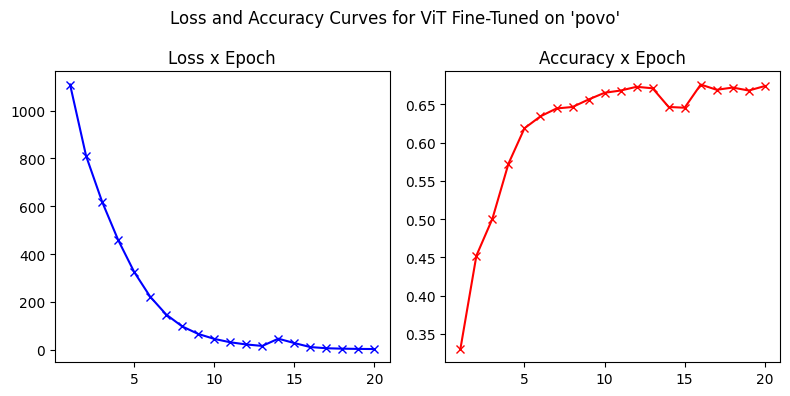

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.67578125
Validation average per class precision: 0.2878
Validation average per class recall: 0.2570

Test accuracy: 0.6645962595939636
Test average per class precision: 0.2680
Test average per class recall: 0.2539

Test average precision on filtered classes: 0.6132828816771507
Test average recall on filtered classes: 0.5974447341301502


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [07:01<2:13:24, 421.29s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1399.6262, Validation Accuracy: 0.4413


Training model:  10%|████▌                                        | 2/20 [14:04<2:06:39, 422.21s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1071.4613, Validation Accuracy: 0.5603


Training model:  15%|██████▊                                      | 3/20 [21:05<1:59:28, 421.68s/it]

Best model saved at epoch 3
Epoch 3, Loss: 763.7295, Validation Accuracy: 0.6448


Training model:  20%|█████████                                    | 4/20 [27:59<1:51:42, 418.89s/it]

Best model saved at epoch 4
Epoch 4, Loss: 470.7962, Validation Accuracy: 0.6870


Training model:  25%|███████████▎                                 | 5/20 [34:56<1:44:32, 418.18s/it]

Best model saved at epoch 5
Epoch 5, Loss: 248.7215, Validation Accuracy: 0.7355


Training model:  30%|█████████████▌                               | 6/20 [41:52<1:37:23, 417.41s/it]

Epoch 6, Loss: 121.2265, Validation Accuracy: 0.7261


Training model:  35%|███████████████▋                             | 7/20 [48:48<1:30:21, 417.03s/it]

Best model saved at epoch 7
Epoch 7, Loss: 66.8772, Validation Accuracy: 0.7371


Training model:  40%|██████████████████                           | 8/20 [55:40<1:23:03, 415.29s/it]

Epoch 8, Loss: 38.5307, Validation Accuracy: 0.7308


Training model:  45%|███████████████████▎                       | 9/20 [1:02:37<1:16:12, 415.72s/it]

Epoch 9, Loss: 26.1827, Validation Accuracy: 0.7167


Training model:  50%|█████████████████████                     | 10/20 [1:09:34<1:09:21, 416.16s/it]

Epoch 10, Loss: 30.7797, Validation Accuracy: 0.7199


Training model:  55%|███████████████████████                   | 11/20 [1:16:33<1:02:33, 417.01s/it]

Epoch 11, Loss: 14.1760, Validation Accuracy: 0.7293


Training model:  60%|██████████████████████████▍                 | 12/20 [1:23:28<55:31, 416.46s/it]

Epoch 12, Loss: 10.3224, Validation Accuracy: 0.7324


Training model:  60%|█████████████████████████▏                | 12/20 [1:30:20<1:00:13, 451.71s/it]


Early-stopping training!


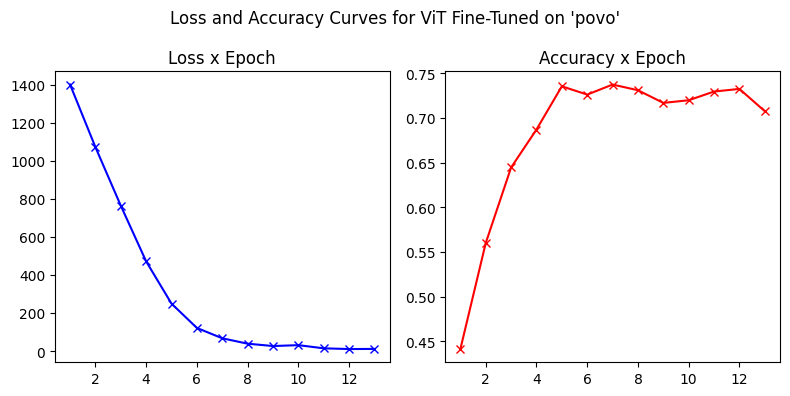

Validation accuracy: 0.7373046875
Validation average per class precision: 0.7476
Validation average per class recall: 0.7036

Test accuracy: 0.7125435471534729
Test average per class precision: 0.7120
Test average per class recall: 0.6529



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:47<00:00,  7.28s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:40<1:47:45, 340.31s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1442.9818, Validation Accuracy: 0.4257


Training model:  10%|████▌                                        | 2/20 [11:11<1:40:31, 335.11s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1173.8958, Validation Accuracy: 0.5336


Training model:  15%|██████▊                                      | 3/20 [16:40<1:34:04, 332.04s/it]

Best model saved at epoch 3
Epoch 3, Loss: 913.2311, Validation Accuracy: 0.6197


Training model:  20%|█████████                                    | 4/20 [22:12<1:28:35, 332.25s/it]

Best model saved at epoch 4
Epoch 4, Loss: 645.9366, Validation Accuracy: 0.6823


Training model:  25%|███████████▎                                 | 5/20 [27:42<1:22:52, 331.47s/it]

Best model saved at epoch 5
Epoch 5, Loss: 401.4139, Validation Accuracy: 0.7199


Training model:  30%|█████████████▌                               | 6/20 [33:11<1:17:09, 330.68s/it]

Best model saved at epoch 6
Epoch 6, Loss: 216.6535, Validation Accuracy: 0.7527


Training model:  35%|███████████████▋                             | 7/20 [38:37<1:11:16, 329.00s/it]

Epoch 7, Loss: 109.6467, Validation Accuracy: 0.7433


Training model:  40%|██████████████████                           | 8/20 [44:03<1:05:37, 328.13s/it]

Best model saved at epoch 8
Epoch 8, Loss: 60.1828, Validation Accuracy: 0.7559


Training model:  45%|████████████████████▎                        | 9/20 [49:30<1:00:03, 327.63s/it]

Epoch 9, Loss: 36.4830, Validation Accuracy: 0.7543


Training model:  50%|███████████████████████                       | 10/20 [54:59<54:42, 328.26s/it]

Epoch 10, Loss: 24.6878, Validation Accuracy: 0.7465


Training model:  55%|████████████████████████▏                   | 11/20 [1:00:26<49:09, 327.77s/it]

Epoch 11, Loss: 16.5738, Validation Accuracy: 0.7496


Training model:  60%|██████████████████████████▍                 | 12/20 [1:05:53<43:39, 327.47s/it]

Epoch 12, Loss: 13.7809, Validation Accuracy: 0.7480


Training model:  65%|████████████████████████████▌               | 13/20 [1:11:23<38:17, 328.17s/it]

Epoch 13, Loss: 10.4300, Validation Accuracy: 0.7496


Training model:  70%|██████████████████████████████▊             | 14/20 [1:16:51<32:49, 328.29s/it]

Epoch 14, Loss: 7.1040, Validation Accuracy: 0.7465


Training model:  75%|█████████████████████████████████           | 15/20 [1:22:19<27:20, 328.05s/it]

Epoch 15, Loss: 6.7502, Validation Accuracy: 0.7402


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:27:48<21:54, 328.53s/it]

Epoch 16, Loss: 4.3455, Validation Accuracy: 0.7465


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:33:14<16:22, 327.51s/it]

Epoch 17, Loss: 5.7579, Validation Accuracy: 0.7465


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:38:37<10:52, 326.33s/it]

Epoch 18, Loss: 3.8849, Validation Accuracy: 0.7387


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:44:06<11:34, 347.03s/it]


Early-stopping training!


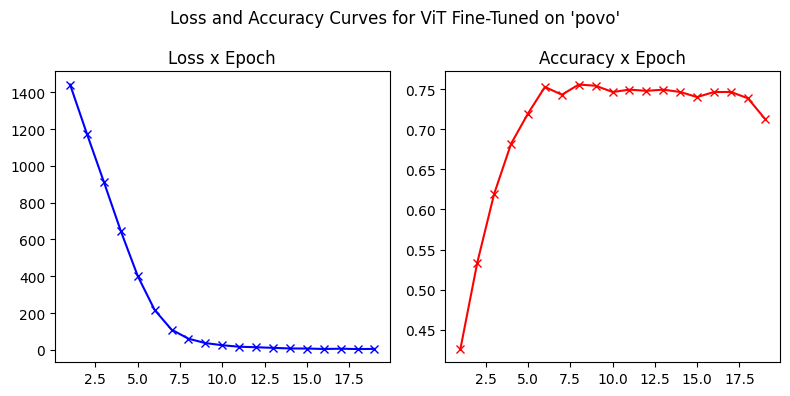

Validation accuracy: 0.755859375
Validation average per class precision: 0.7463
Validation average per class recall: 0.7139



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.700348436832428
Test average per class precision: 0.7023
Test average per class recall: 0.6473



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

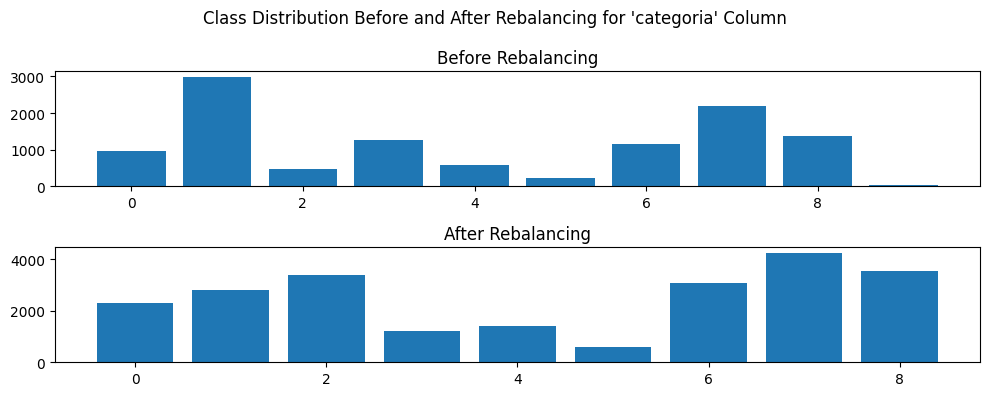

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:05<1:17:38, 245.17s/it]

Best model saved at epoch 1
Epoch 1, Loss: 471.9971, Validation Accuracy: 0.6532


Training model:  10%|████▌                                        | 2/20 [08:05<1:12:38, 242.16s/it]

Best model saved at epoch 2
Epoch 2, Loss: 293.7214, Validation Accuracy: 0.7872


Training model:  15%|██████▊                                      | 3/20 [12:04<1:08:12, 240.71s/it]

Best model saved at epoch 3
Epoch 3, Loss: 206.6466, Validation Accuracy: 0.8236


Training model:  20%|█████████                                    | 4/20 [16:03<1:03:59, 239.96s/it]

Best model saved at epoch 4
Epoch 4, Loss: 147.8501, Validation Accuracy: 0.8473


Training model:  25%|███████████▊                                   | 5/20 [20:02<59:54, 239.65s/it]

Best model saved at epoch 5
Epoch 5, Loss: 107.3391, Validation Accuracy: 0.8650


Training model:  30%|██████████████                                 | 6/20 [24:00<55:50, 239.31s/it]

Best model saved at epoch 6
Epoch 6, Loss: 76.2842, Validation Accuracy: 0.8759


Training model:  35%|████████████████▍                              | 7/20 [28:00<51:50, 239.29s/it]

Best model saved at epoch 7
Epoch 7, Loss: 55.9782, Validation Accuracy: 0.8837


Training model:  40%|██████████████████▊                            | 8/20 [31:57<47:46, 238.84s/it]

Epoch 8, Loss: 41.4644, Validation Accuracy: 0.8631


Training model:  45%|█████████████████████▏                         | 9/20 [35:56<43:45, 238.67s/it]

Epoch 9, Loss: 31.6140, Validation Accuracy: 0.8778


Training model:  50%|███████████████████████                       | 10/20 [39:53<39:43, 238.33s/it]

Epoch 10, Loss: 25.7782, Validation Accuracy: 0.8571


Training model:  50%|███████████████████████                       | 10/20 [43:51<43:51, 263.19s/it]

Early-stopping training!


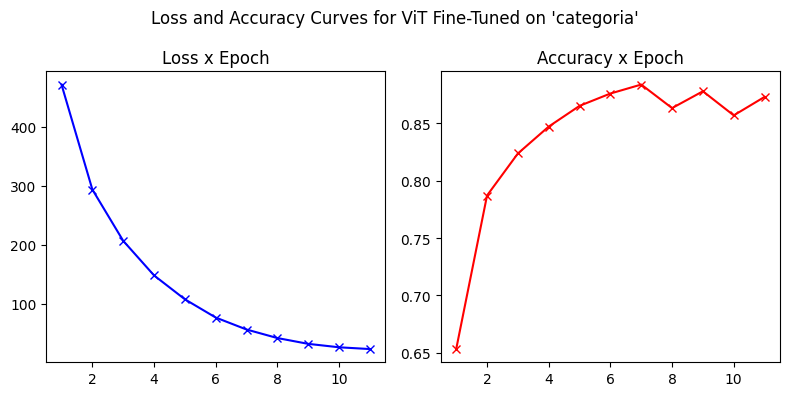

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Validation accuracy: 0.8837890625
Validation average per class precision: 0.7746
Validation average per class recall: 0.7825

Test accuracy: 0.8571428656578064
Test average per class precision: 0.7551
Test average per class recall: 0.7482

Test average precision on filtered classes: 0.8390199806955125
Test average recall on filtered classes: 0.83137889040841


In [19]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [11:32<3:39:22, 692.78s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2458.4507, Validation Accuracy: 0.6753


Training model:  10%|████▌                                        | 2/20 [23:13<3:29:12, 697.38s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1496.2918, Validation Accuracy: 0.7755


Training model:  15%|██████▊                                      | 3/20 [34:54<3:18:02, 698.94s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1036.5724, Validation Accuracy: 0.8178


Training model:  20%|█████████                                    | 4/20 [46:38<3:06:58, 701.18s/it]

Best model saved at epoch 4
Epoch 4, Loss: 734.3869, Validation Accuracy: 0.8399


Training model:  25%|███████████▎                                 | 5/20 [58:21<2:55:28, 701.89s/it]

Best model saved at epoch 5
Epoch 5, Loss: 515.0631, Validation Accuracy: 0.8519


Training model:  30%|████████████▉                              | 6/20 [1:10:01<2:43:36, 701.20s/it]

Best model saved at epoch 6
Epoch 6, Loss: 364.4063, Validation Accuracy: 0.8657


Training model:  35%|███████████████                            | 7/20 [1:21:44<2:32:04, 701.85s/it]

Best model saved at epoch 7
Epoch 7, Loss: 255.2944, Validation Accuracy: 0.8684


Training model:  40%|█████████████████▏                         | 8/20 [1:33:29<2:20:31, 702.61s/it]

Best model saved at epoch 8
Epoch 8, Loss: 183.4540, Validation Accuracy: 0.8730


Training model:  45%|███████████████████▎                       | 9/20 [1:45:15<2:08:59, 703.60s/it]

Epoch 9, Loss: 132.7581, Validation Accuracy: 0.8721


Training model:  50%|█████████████████████                     | 10/20 [1:56:49<1:56:49, 700.91s/it]

Best model saved at epoch 10
Epoch 10, Loss: 98.2949, Validation Accuracy: 0.8749


Training model:  55%|███████████████████████                   | 11/20 [2:08:37<1:45:26, 702.97s/it]

Best model saved at epoch 11
Epoch 11, Loss: 75.7908, Validation Accuracy: 0.8758


Training model:  60%|█████████████████████████▏                | 12/20 [2:20:20<1:33:42, 702.86s/it]

Best model saved at epoch 12
Epoch 12, Loss: 64.1273, Validation Accuracy: 0.8795


Training model:  65%|███████████████████████████▎              | 13/20 [2:32:08<1:22:10, 704.41s/it]

Best model saved at epoch 13
Epoch 13, Loss: 52.2480, Validation Accuracy: 0.8813


Training model:  70%|█████████████████████████████▍            | 14/20 [2:43:51<1:10:24, 704.06s/it]

Epoch 14, Loss: 47.7211, Validation Accuracy: 0.8740


Training model:  75%|█████████████████████████████████           | 15/20 [2:55:37<58:43, 704.73s/it]

Epoch 15, Loss: 39.4582, Validation Accuracy: 0.8740


Training model:  80%|███████████████████████████████████▏        | 16/20 [3:07:20<46:57, 704.31s/it]

Best model saved at epoch 16
Epoch 16, Loss: 38.3197, Validation Accuracy: 0.8832


Training model:  85%|█████████████████████████████████████▍      | 17/20 [3:19:11<35:18, 706.17s/it]

Best model saved at epoch 17
Epoch 17, Loss: 29.3433, Validation Accuracy: 0.8841


Training model:  90%|███████████████████████████████████████▌    | 18/20 [3:30:56<23:31, 705.80s/it]

Best model saved at epoch 18
Epoch 18, Loss: 27.0427, Validation Accuracy: 0.8868


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:42:35<11:43, 703.64s/it]

Epoch 19, Loss: 26.2976, Validation Accuracy: 0.8758


Training model: 100%|████████████████████████████████████████████| 20/20 [3:54:23<00:00, 703.17s/it]


Epoch 20, Loss: 24.2004, Validation Accuracy: 0.8832


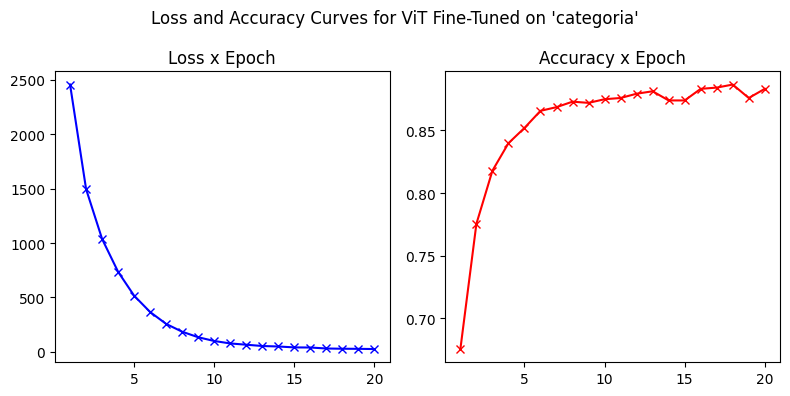

Validation accuracy: 0.88671875
Validation average per class precision: 0.8863
Validation average per class recall: 0.8662

Test accuracy: 0.8670756816864014
Test average per class precision: 0.8670
Test average per class recall: 0.8317



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:47<00:00,  7.28s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [20]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [09:19<2:57:07, 559.37s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2642.4754, Validation Accuracy: 0.6587


Training model:  10%|████▌                                        | 2/20 [18:42<2:48:28, 561.59s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1790.0433, Validation Accuracy: 0.7314


Training model:  15%|██████▊                                      | 3/20 [28:03<2:39:05, 561.51s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1287.2171, Validation Accuracy: 0.7792


Training model:  20%|█████████                                    | 4/20 [37:37<2:31:00, 566.31s/it]

Best model saved at epoch 4
Epoch 4, Loss: 973.5170, Validation Accuracy: 0.8105


Training model:  25%|███████████▎                                 | 5/20 [47:58<2:26:29, 585.99s/it]

Best model saved at epoch 5
Epoch 5, Loss: 739.2763, Validation Accuracy: 0.8298


Training model:  30%|█████████████▌                               | 6/20 [58:41<2:21:16, 605.50s/it]

Best model saved at epoch 6
Epoch 6, Loss: 555.9159, Validation Accuracy: 0.8500


Training model:  35%|███████████████                            | 7/20 [1:09:12<2:12:59, 613.80s/it]

Best model saved at epoch 7
Epoch 7, Loss: 409.3413, Validation Accuracy: 0.8611


Training model:  40%|█████████████████▏                         | 8/20 [1:19:01<2:01:10, 605.88s/it]

Best model saved at epoch 8
Epoch 8, Loss: 304.9969, Validation Accuracy: 0.8767


Training model:  45%|███████████████████▎                       | 9/20 [1:28:33<1:49:08, 595.33s/it]

Best model saved at epoch 9
Epoch 9, Loss: 221.1207, Validation Accuracy: 0.8804


Training model:  50%|█████████████████████                     | 10/20 [1:37:53<1:37:22, 584.26s/it]

Best model saved at epoch 10
Epoch 10, Loss: 165.1468, Validation Accuracy: 0.8868


Training model:  55%|███████████████████████                   | 11/20 [1:47:09<1:26:22, 575.83s/it]

Best model saved at epoch 11
Epoch 11, Loss: 122.4048, Validation Accuracy: 0.8905


Training model:  60%|█████████████████████████▏                | 12/20 [1:57:01<1:17:25, 580.65s/it]

Epoch 12, Loss: 92.5468, Validation Accuracy: 0.8850


Training model:  65%|███████████████████████████▎              | 13/20 [2:06:50<1:08:01, 583.12s/it]

Epoch 13, Loss: 66.4823, Validation Accuracy: 0.8905


Training model:  70%|██████████████████████████████▊             | 14/20 [2:16:41<58:32, 585.38s/it]

Best model saved at epoch 14
Epoch 14, Loss: 49.1700, Validation Accuracy: 0.8951


Training model:  75%|█████████████████████████████████           | 15/20 [2:26:26<48:46, 585.29s/it]

Epoch 15, Loss: 36.3892, Validation Accuracy: 0.8887


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:35:52<38:38, 579.63s/it]

Epoch 16, Loss: 27.4386, Validation Accuracy: 0.8850


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:45:11<28:40, 573.38s/it]

Epoch 17, Loss: 21.9311, Validation Accuracy: 0.8942


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:54:28<18:57, 568.57s/it]

Best model saved at epoch 18
Epoch 18, Loss: 18.2183, Validation Accuracy: 0.8970


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [3:03:47<09:25, 565.50s/it]

Epoch 19, Loss: 15.4088, Validation Accuracy: 0.8859


Training model: 100%|████████████████████████████████████████████| 20/20 [3:13:11<00:00, 579.58s/it]


Epoch 20, Loss: 12.9656, Validation Accuracy: 0.8887


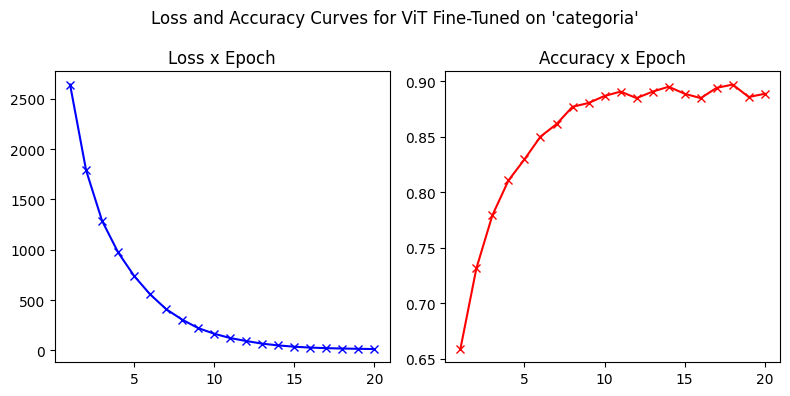

Validation accuracy: 0.89697265625
Validation average per class precision: 0.9046
Validation average per class recall: 0.8725



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8854805827140808
Test average per class precision: 0.8781
Test average per class recall: 0.8504



In [21]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

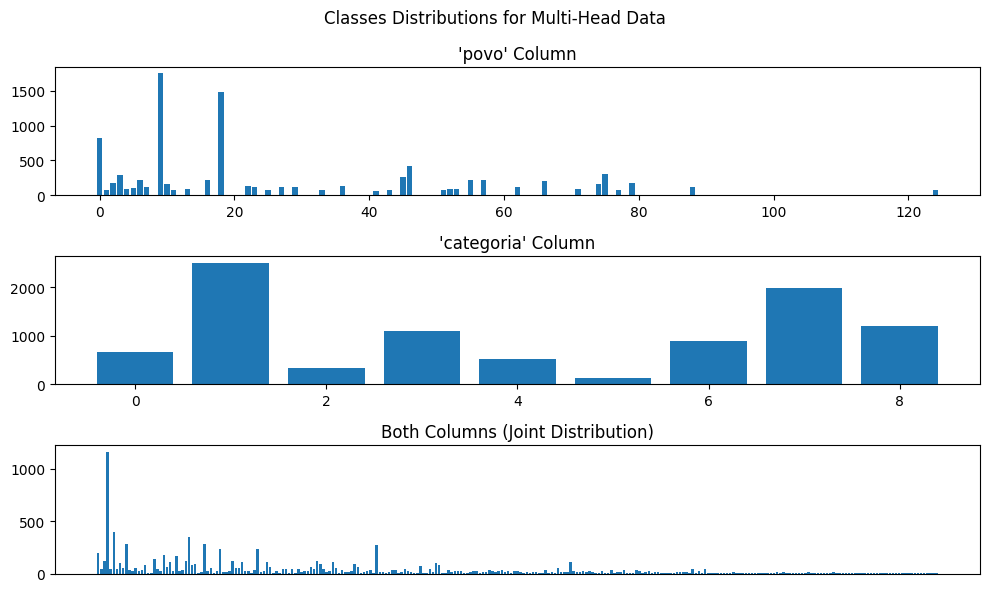

In [22]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [23]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

Quantile X Data Percentage:
Q-10: 75.00, 96.14% of data
Q-25: 86.00, 91.77% of data
Q-50: 123.00, 80.30% of data
Q-75: 216.50, 64.05% of data
Q-90: 327.40, 47.86% of data

Quantile X Data Percentage:
Q-10: 302.40, 98.63% of data
Q-25: 515.00, 89.42% of data
Q-50: 887.00, 72.71% of data
Q-75: 1203.00, 48.06% of data
Q-90: 2089.00, 26.84% of data



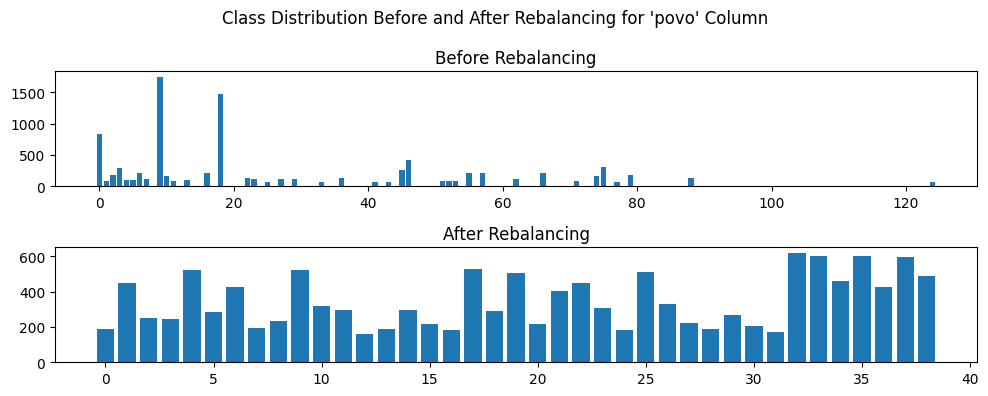

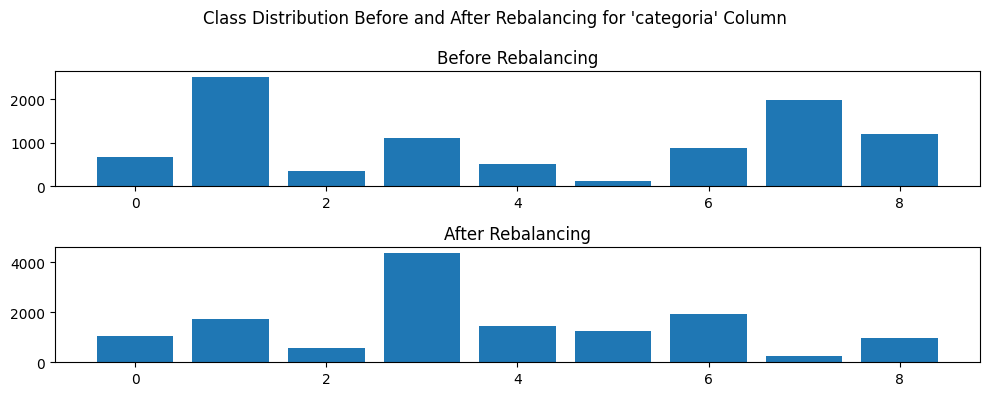

In [24]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [25]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   5%|██▎                                          | 1/20 [07:33<2:23:37, 453.57s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 2461.5667, Validation Average Accuracy: 0.5176


Training model:  10%|████▌                                        | 2/20 [15:07<2:16:07, 453.74s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 1990.7321, Validation Average Accuracy: 0.5923


Training model:  15%|██████▊                                      | 3/20 [22:34<2:07:40, 450.60s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 1641.3628, Validation Average Accuracy: 0.6582


Training model:  20%|█████████                                    | 4/20 [29:55<1:59:09, 446.82s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 1316.7536, Validation Average Accuracy: 0.7090


Training model:  25%|███████████▎                                 | 5/20 [37:27<1:52:11, 448.77s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 1006.4119, Validation Average Accuracy: 0.7383


Training model:  30%|█████████████▌                               | 6/20 [44:59<1:44:58, 449.93s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 727.5933, Validation Average Accuracy: 0.7612


Training model:  35%|███████████████▋                             | 7/20 [52:14<1:36:24, 445.00s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 495.7793, Validation Average Accuracy: 0.7881


Training model:  40%|██████████████████                           | 8/20 [59:36<1:28:49, 444.13s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 328.5042, Validation Average Accuracy: 0.8013


Training model:  45%|███████████████████▎                       | 9/20 [1:06:53<1:20:59, 441.78s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 215.0121, Validation Average Accuracy: 0.8047


Training model:  50%|█████████████████████                     | 10/20 [1:14:21<1:13:56, 443.67s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 143.0309, Validation Average Accuracy: 0.8101


Training model:  55%|███████████████████████                   | 11/20 [1:21:32<1:05:59, 439.98s/it]

Best model saved at epoch 11
Epoch 11, Combined Loss: 97.7371, Validation Average Accuracy: 0.8184


Training model:  60%|██████████████████████████▍                 | 12/20 [1:28:41<58:12, 436.52s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 68.4208, Validation Average Accuracy: 0.8193


Training model:  65%|████████████████████████████▌               | 13/20 [1:35:46<50:30, 432.96s/it]

Epoch 13, Combined Loss: 52.7201, Validation Average Accuracy: 0.8184


Training model:  70%|██████████████████████████████▊             | 14/20 [1:42:48<42:57, 429.66s/it]

Epoch 14, Combined Loss: 33.4567, Validation Average Accuracy: 0.8193


Training model:  75%|█████████████████████████████████           | 15/20 [1:49:45<35:28, 425.80s/it]

Best model saved at epoch 15
Epoch 15, Combined Loss: 24.0977, Validation Average Accuracy: 0.8203


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:56:38<28:08, 422.10s/it]

Epoch 16, Combined Loss: 19.7802, Validation Average Accuracy: 0.8057


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:03:32<20:58, 419.49s/it]

Best model saved at epoch 17
Epoch 17, Combined Loss: 18.0162, Validation Average Accuracy: 0.8218


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:10:30<13:58, 419.26s/it]

Epoch 18, Combined Loss: 11.8992, Validation Average Accuracy: 0.8179


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:18:05<07:09, 429.76s/it]

Epoch 19, Combined Loss: 9.1801, Validation Average Accuracy: 0.8076


Training model: 100%|████████████████████████████████████████████| 20/20 [2:25:30<00:00, 436.54s/it]


Epoch 20, Combined Loss: 14.8425, Validation Average Accuracy: 0.8135


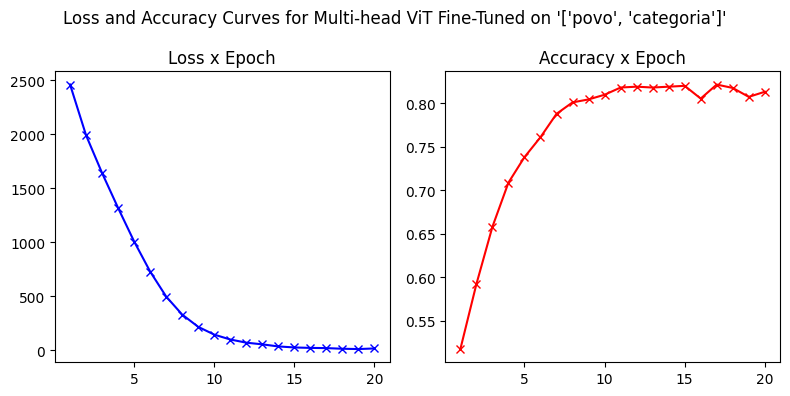

Validation 'povo' head accuracy: 0.728515625
Validation 'categoria' head accuracy: 0.9150390625
Validation average accuracy: 0.82177734375

Validation 'povo' head average per class precision: 0.7338
Validation 'povo' head average per class recall: 0.6958

Validation 'categoria' head average per class precision: 0.9097
Validation 'categoria' head average per class recall: 0.8830



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test 'povo' head accuracy: 0.6865149140357971
Test 'categoria' head accuracy: 0.8879159092903137
Test average accuracy: 0.787109375

Test 'povo' head average per class precision: 0.6701
Test 'povo' head average per class recall: 0.6217

Test 'categoria' head average per class precision: 0.8841
Test 'categoria' head average per class recall: 0.8814



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:53<00:00,  7.56s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.7, 0.3]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [27]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

multihead_vit_trimap = normalize(multihead_vit_trimap, norm_factor)
multihead_vit_tsne = normalize(multihead_vit_tsne, norm_factor)
multihead_vit_umap = normalize(multihead_vit_umap, norm_factor)

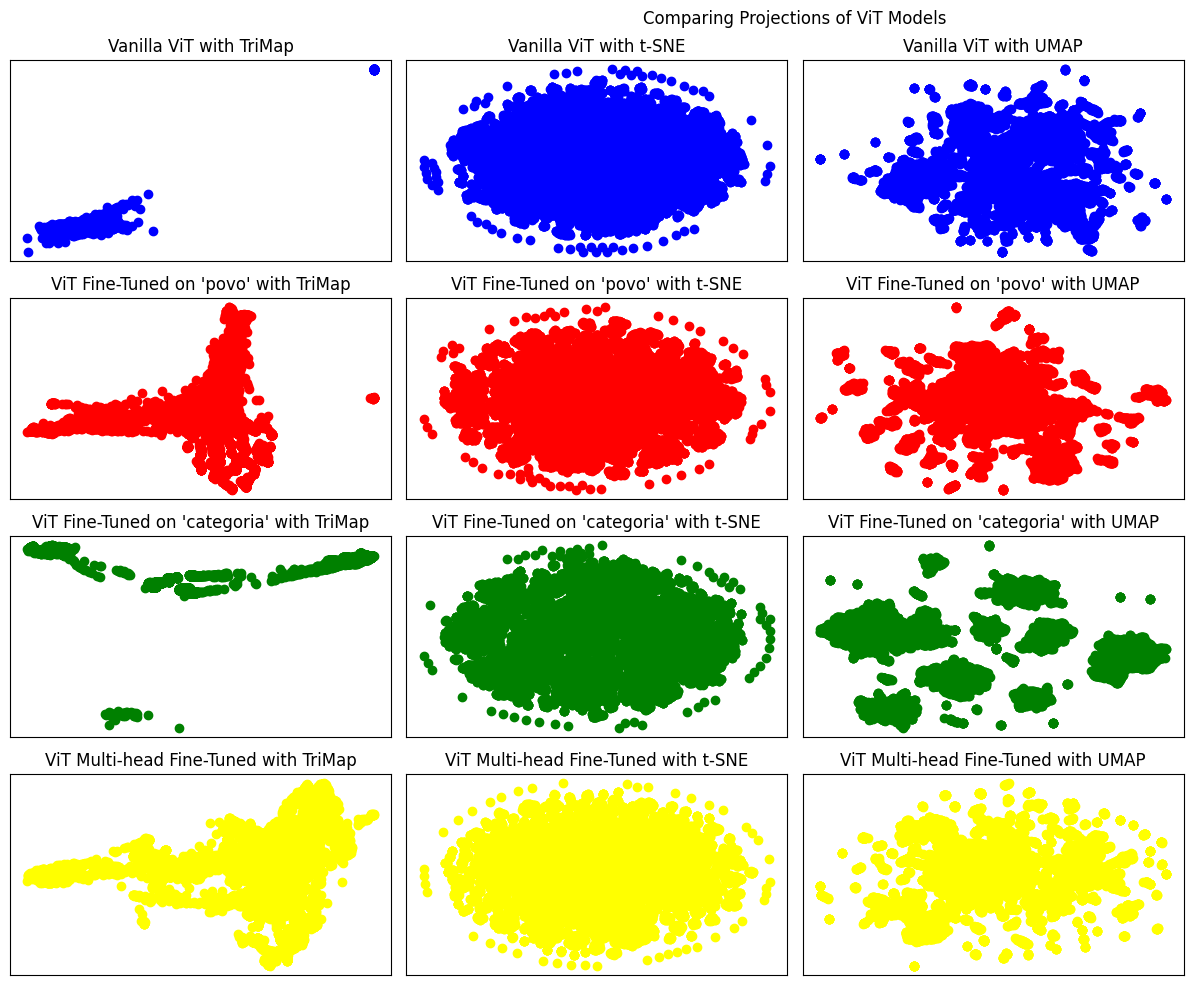

In [28]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=4, cols=4):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(16,10))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# Plotting ViT fine-tuned on 'povo' and 'categoria' (multi-head) projections
projs = [multihead_vit_trimap, multihead_vit_tsne, multihead_vit_umap]
proj_names = ["ViT Multi-head Fine-Tuned with TriMap", \
              "ViT Multi-head Fine-Tuned with t-SNE", \
              "ViT Multi-head Fine-Tuned with UMAP"]
row_scatter_plot(projs, proj_names, 4, 'yellow')

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


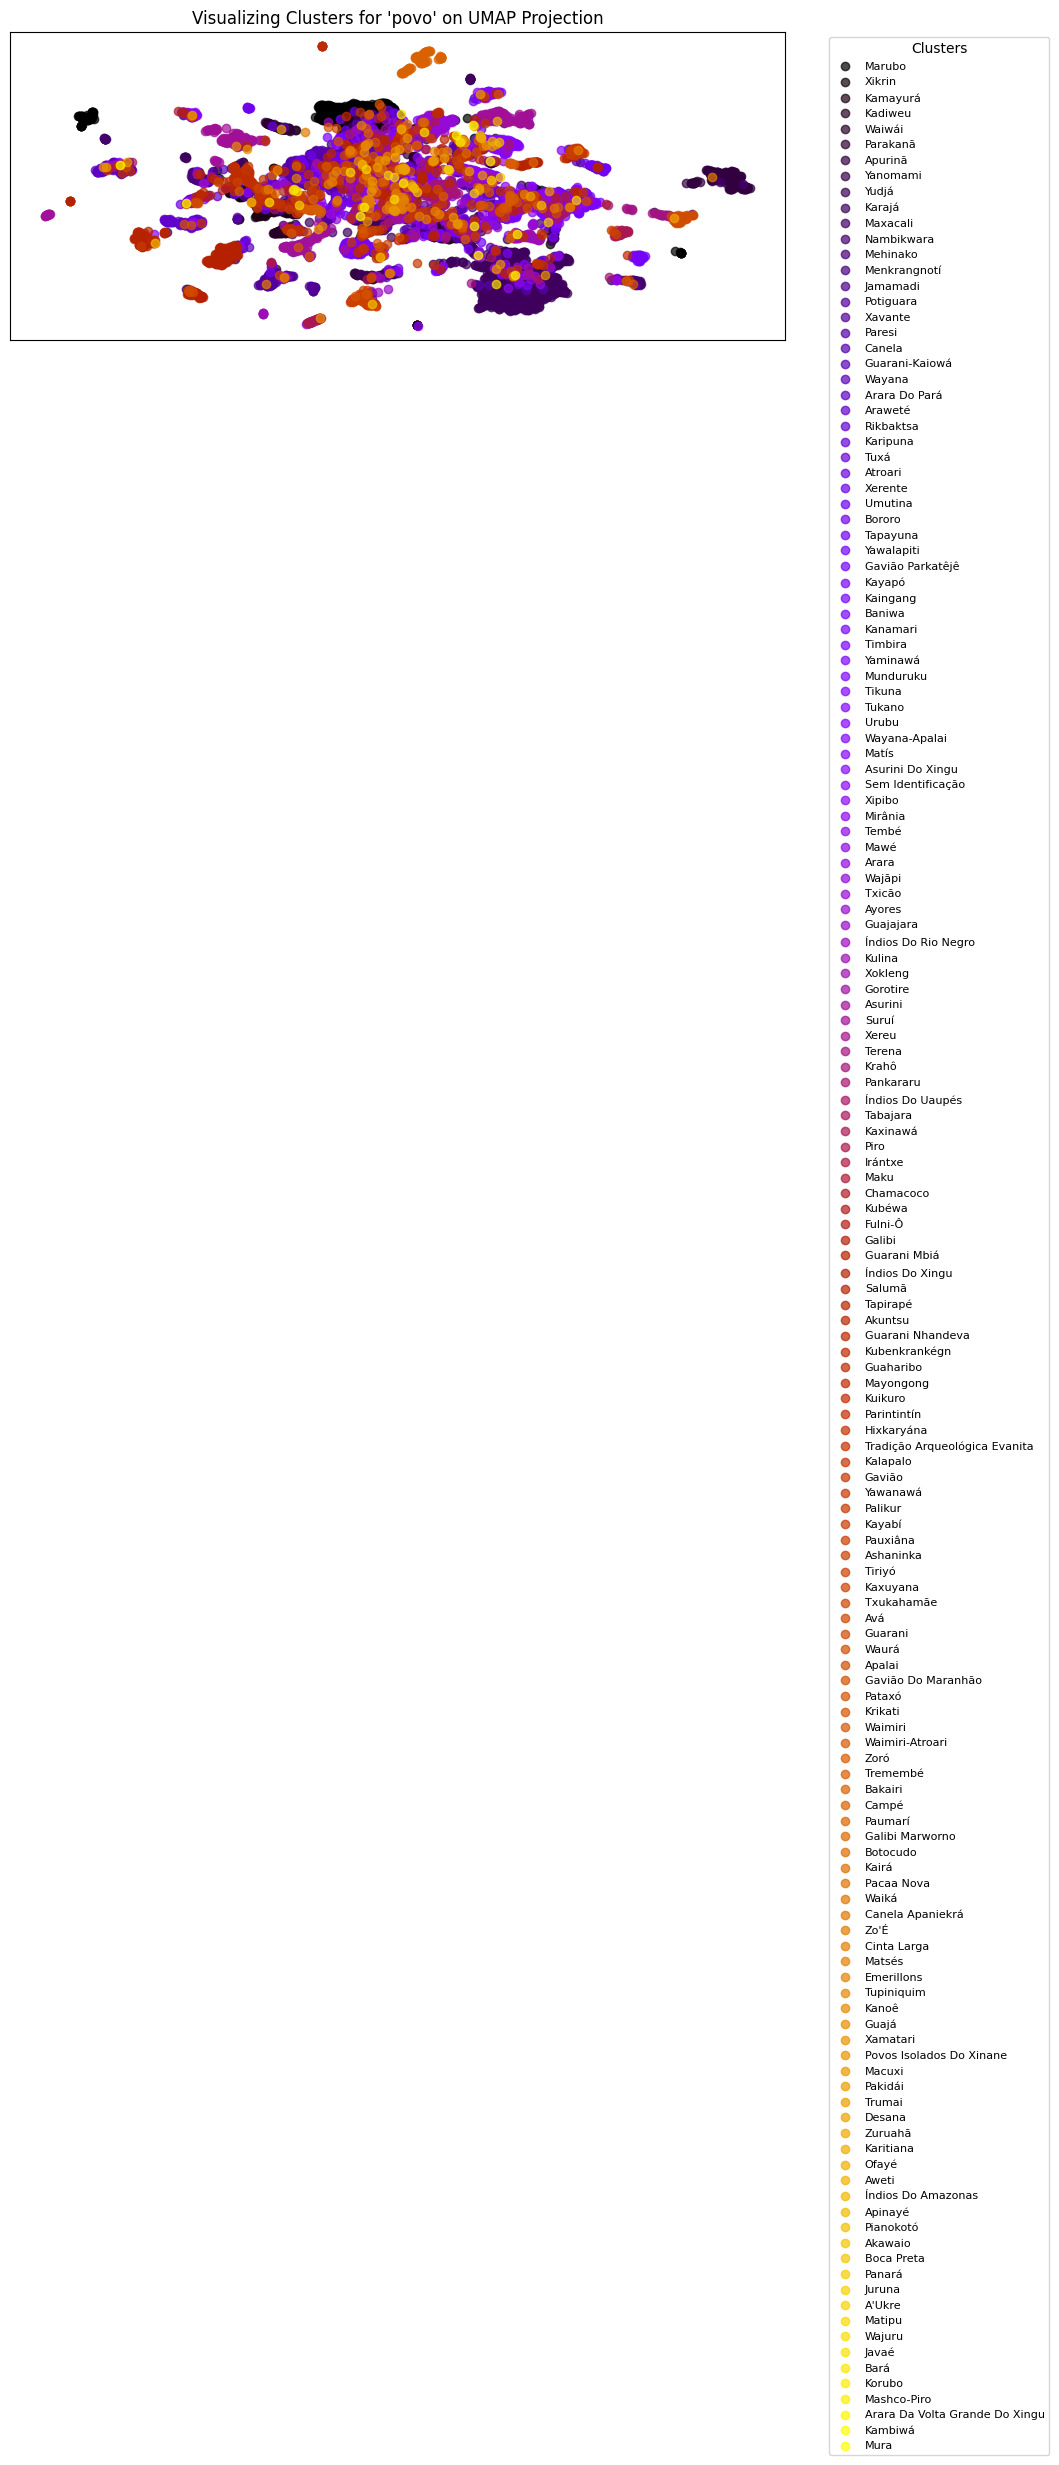

In [29]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

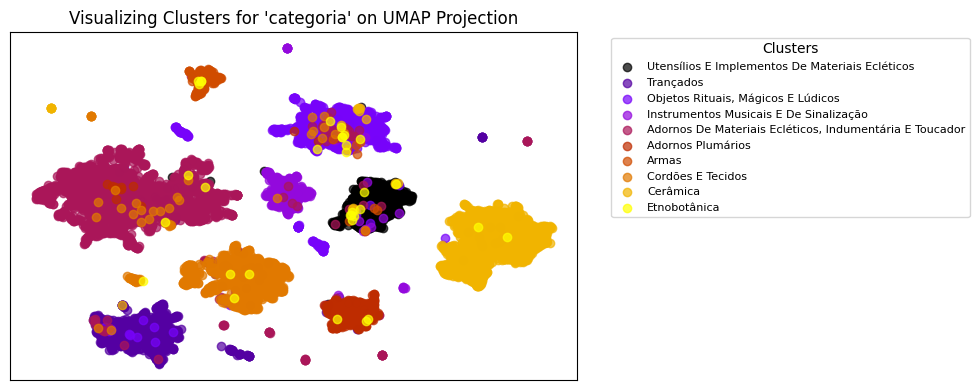

In [30]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

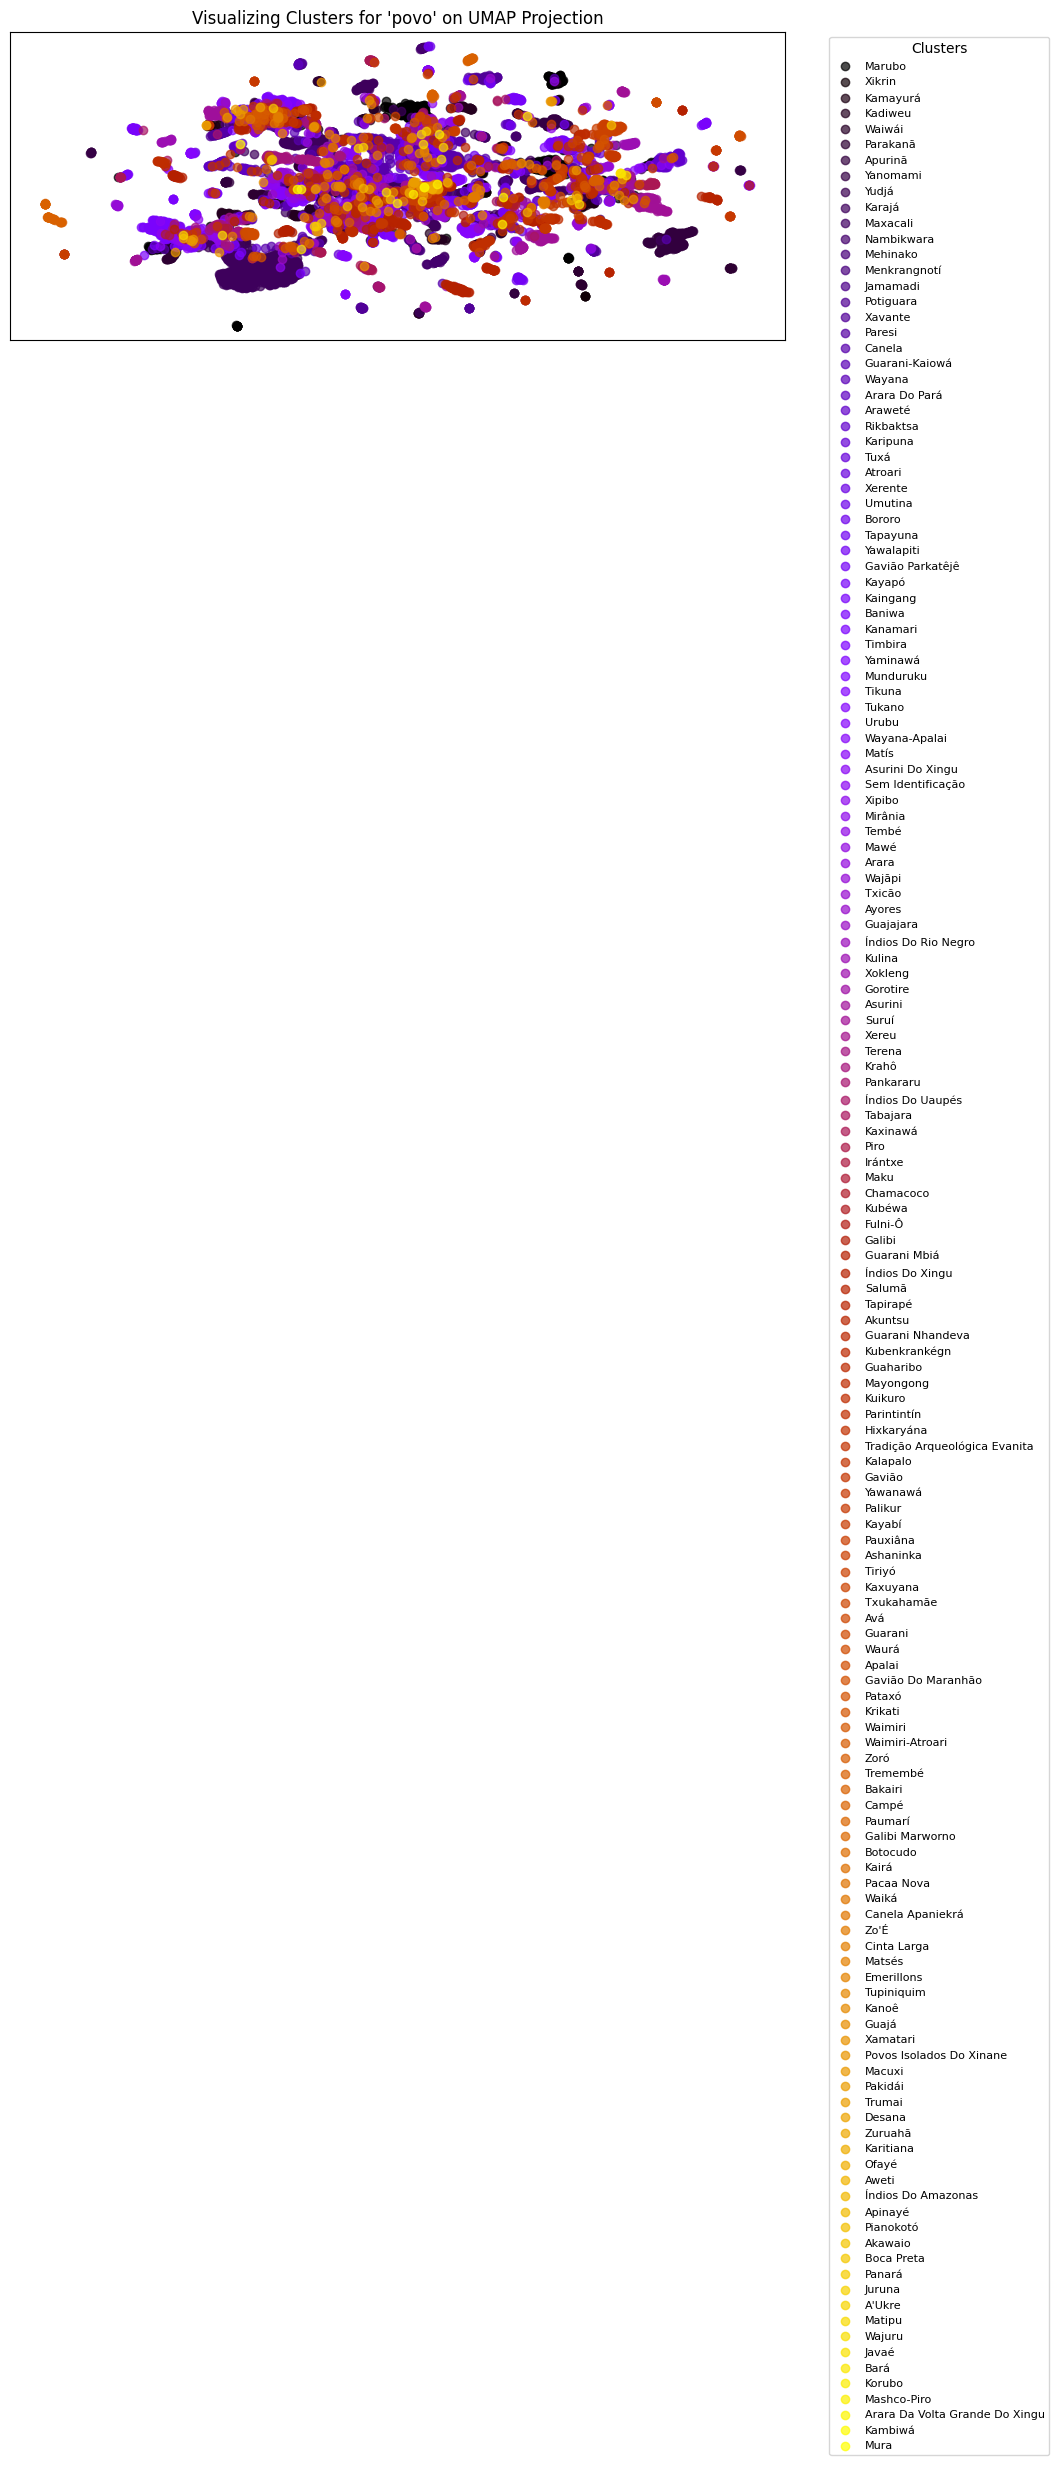

In [31]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'povo', 'UMAP')

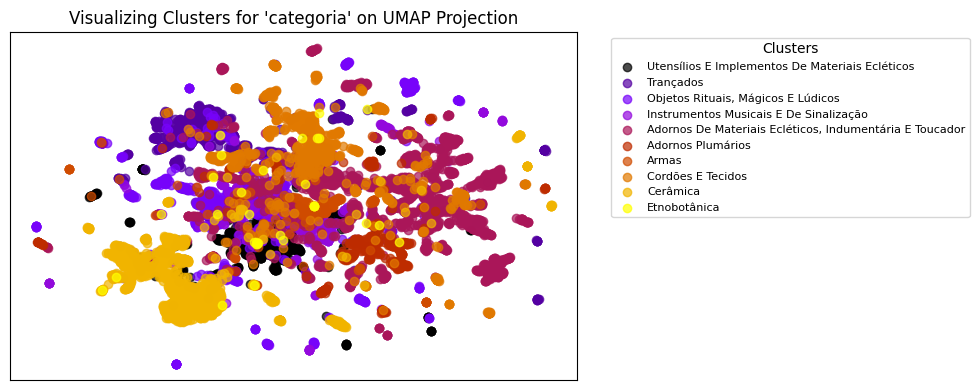

In [32]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_vit_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [33]:
# Saving outputs for visualization tool
# _ = saving_outputs(filtered_df, povo_labels, vanilla_vit_umap, vanilla_image_indices, \
#                    save_file='vanilla_vit.csv', no_clusters=True)

# _ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
#                    'povo_vit.csv')

# _ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
#                    categoria_image_indices, 'categoria', 'categoria_vit.csv')

# _ = saving_outputs(filtered_df, povo_labels, multihead_vit_umap, \
#                    multihead_image_indices, save_file='multihead_vit.csv', no_clusters=True)

## DINOv2

### Pre-Trained Embedding Space

In [34]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, vanilla_image_indices = get_embeddings(model, povo_dataloader, device, \
                                                         model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)
vanilla_image_indices = np.concatenate(vanilla_image_indices, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|███████████████████████████████████████| 705/705 [03:06<00:00,  3.78it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [35]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.dino.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

Training model:   5%|██▎                                          | 1/20 [05:22<1:42:06, 322.42s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2000.3569, Validation Accuracy: 0.3734


Training model:  10%|████▌                                        | 2/20 [10:41<1:36:11, 320.63s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1443.1587, Validation Accuracy: 0.4355


Training model:  15%|██████▊                                      | 3/20 [16:03<1:30:59, 321.12s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1134.8088, Validation Accuracy: 0.4847


Training model:  20%|█████████                                    | 4/20 [21:26<1:25:52, 322.01s/it]

Best model saved at epoch 4
Epoch 4, Loss: 877.8836, Validation Accuracy: 0.5330


Training model:  25%|███████████▎                                 | 5/20 [26:48<1:20:25, 321.72s/it]

Best model saved at epoch 5
Epoch 5, Loss: 662.4806, Validation Accuracy: 0.5547


Training model:  30%|█████████████▌                               | 6/20 [32:13<1:15:22, 323.01s/it]

Best model saved at epoch 6
Epoch 6, Loss: 482.6785, Validation Accuracy: 0.5734


Training model:  35%|███████████████▋                             | 7/20 [37:32<1:09:39, 321.51s/it]

Best model saved at epoch 7
Epoch 7, Loss: 340.5327, Validation Accuracy: 0.5793


Training model:  40%|██████████████████                           | 8/20 [42:58<1:04:36, 323.03s/it]

Best model saved at epoch 8
Epoch 8, Loss: 232.9566, Validation Accuracy: 0.5842


Training model:  45%|█████████████████████▏                         | 9/20 [48:23<59:19, 323.60s/it]

Epoch 9, Loss: 153.5213, Validation Accuracy: 0.5833


Training model:  50%|███████████████████████                       | 10/20 [53:46<53:55, 323.50s/it]

Best model saved at epoch 10
Epoch 10, Loss: 99.8049, Validation Accuracy: 0.5951


Training model:  55%|█████████████████████████▎                    | 11/20 [59:07<48:25, 322.84s/it]

Epoch 11, Loss: 65.3176, Validation Accuracy: 0.5921


Training model:  60%|██████████████████████████▍                 | 12/20 [1:04:25<42:51, 321.39s/it]

Best model saved at epoch 12
Epoch 12, Loss: 44.1243, Validation Accuracy: 0.6099


Training model:  65%|████████████████████████████▌               | 13/20 [1:09:37<37:08, 318.34s/it]

Epoch 13, Loss: 31.2007, Validation Accuracy: 0.6039


Training model:  70%|██████████████████████████████▊             | 14/20 [1:14:38<31:18, 313.15s/it]

Epoch 14, Loss: 22.9935, Validation Accuracy: 0.6030


Training model:  75%|█████████████████████████████████           | 15/20 [1:19:38<25:46, 309.38s/it]

Epoch 15, Loss: 17.6372, Validation Accuracy: 0.6010


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:24:41<20:29, 307.42s/it]

Epoch 16, Loss: 13.4702, Validation Accuracy: 0.6039


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:29:55<15:28, 309.39s/it]

Epoch 17, Loss: 12.1046, Validation Accuracy: 0.6049


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:35:16<10:25, 312.64s/it]

Epoch 18, Loss: 11.5523, Validation Accuracy: 0.6099


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:40:35<05:14, 314.82s/it]

Epoch 19, Loss: 10.3671, Validation Accuracy: 0.5990


Training model: 100%|████████████████████████████████████████████| 20/20 [1:45:58<00:00, 317.94s/it]


Epoch 20, Loss: 9.4631, Validation Accuracy: 0.6099


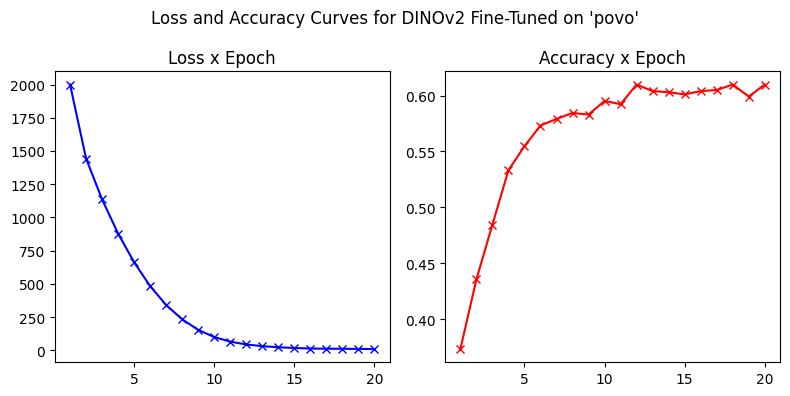

Validation accuracy: 0.60986328125
Validation average per class precision: 0.2453
Validation average per class recall: 0.1946



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.6220053434371948
Test average per class precision: 0.2342
Test average per class recall: 0.1869

Test average precision on filtered classes: 0.5972692721929306
Test average recall on filtered classes: 0.5088776663327829


In [36]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [37]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

Training model:   5%|██▎                                          | 1/20 [08:34<2:42:57, 514.60s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2408.2293, Validation Accuracy: 0.4085


Training model:  10%|████▌                                        | 2/20 [16:59<2:32:41, 508.99s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1356.2403, Validation Accuracy: 0.5133


Training model:  15%|██████▊                                      | 3/20 [25:27<2:24:00, 508.24s/it]

Best model saved at epoch 3
Epoch 3, Loss: 839.4822, Validation Accuracy: 0.5603


Training model:  20%|█████████                                    | 4/20 [33:49<2:14:53, 505.87s/it]

Best model saved at epoch 4
Epoch 4, Loss: 526.1815, Validation Accuracy: 0.5994


Training model:  25%|███████████▎                                 | 5/20 [42:16<2:06:34, 506.32s/it]

Best model saved at epoch 5
Epoch 5, Loss: 334.9892, Validation Accuracy: 0.6213


Training model:  30%|█████████████▌                               | 6/20 [50:35<1:57:33, 503.79s/it]

Best model saved at epoch 6
Epoch 6, Loss: 209.3445, Validation Accuracy: 0.6244


Training model:  35%|███████████████▋                             | 7/20 [58:53<1:48:43, 501.83s/it]

Best model saved at epoch 7
Epoch 7, Loss: 136.7286, Validation Accuracy: 0.6401


Training model:  40%|█████████████████▏                         | 8/20 [1:07:18<1:40:34, 502.84s/it]

Best model saved at epoch 8
Epoch 8, Loss: 91.2272, Validation Accuracy: 0.6479


Training model:  45%|███████████████████▎                       | 9/20 [1:15:39<1:32:07, 502.53s/it]

Epoch 9, Loss: 62.0716, Validation Accuracy: 0.6385


Training model:  50%|█████████████████████                     | 10/20 [1:24:13<1:24:17, 505.80s/it]

Epoch 10, Loss: 42.9755, Validation Accuracy: 0.6338


Training model:  55%|███████████████████████                   | 11/20 [1:33:06<1:17:07, 514.13s/it]

Epoch 11, Loss: 32.8859, Validation Accuracy: 0.6401


Training model:  60%|█████████████████████████▏                | 12/20 [1:41:55<1:09:09, 518.71s/it]

Epoch 12, Loss: 22.5330, Validation Accuracy: 0.6416


Training model:  65%|███████████████████████████▎              | 13/20 [1:50:22<1:00:06, 515.19s/it]

Best model saved at epoch 13
Epoch 13, Loss: 17.7188, Validation Accuracy: 0.6526


Training model:  70%|██████████████████████████████▊             | 14/20 [1:58:52<51:22, 513.80s/it]

Best model saved at epoch 14
Epoch 14, Loss: 14.9187, Validation Accuracy: 0.6588


Training model:  75%|█████████████████████████████████           | 15/20 [2:07:22<42:42, 512.53s/it]

Best model saved at epoch 15
Epoch 15, Loss: 12.1432, Validation Accuracy: 0.6620


Training model:  80%|███████████████████████████████████▏        | 16/20 [2:15:50<34:04, 511.05s/it]

Epoch 16, Loss: 8.9040, Validation Accuracy: 0.6432


Training model:  85%|█████████████████████████████████████▍      | 17/20 [2:24:35<25:46, 515.47s/it]

Epoch 17, Loss: 9.9498, Validation Accuracy: 0.6573


Training model:  90%|███████████████████████████████████████▌    | 18/20 [2:33:22<17:17, 518.83s/it]

Epoch 18, Loss: 4.0727, Validation Accuracy: 0.6588


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [2:42:04<08:39, 519.74s/it]

Epoch 19, Loss: 11.3760, Validation Accuracy: 0.6463


Training model: 100%|████████████████████████████████████████████| 20/20 [2:50:46<00:00, 512.33s/it]


Best model saved at epoch 20
Epoch 20, Loss: 3.9150, Validation Accuracy: 0.6635


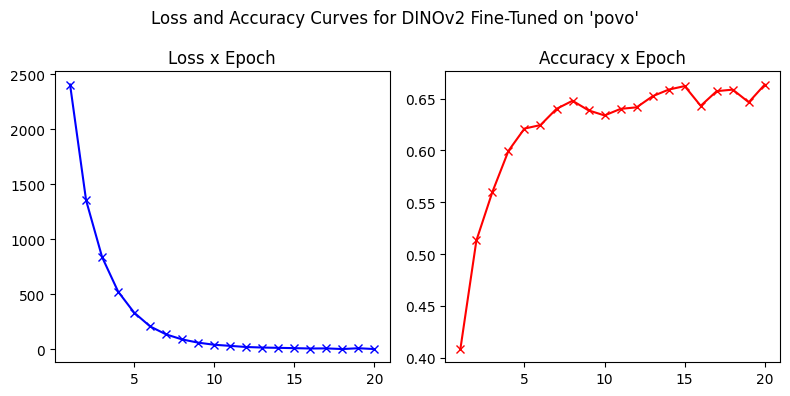

Validation accuracy: 0.66357421875
Validation average per class precision: 0.6282
Validation average per class recall: 0.6215



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.7125435471534729
Test average per class precision: 0.6954
Test average per class recall: 0.6709



In [38]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
#                                                                    device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:50<1:50:56, 350.32s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2696.0212, Validation Accuracy: 0.3099


Training model:  10%|████▌                                        | 2/20 [11:36<1:44:23, 348.00s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1793.2927, Validation Accuracy: 0.4304


Training model:  15%|██████▊                                      | 3/20 [17:26<1:38:53, 349.01s/it]

Best model saved at epoch 3
Epoch 3, Loss: 1351.6078, Validation Accuracy: 0.4977


Training model:  20%|█████████                                    | 4/20 [23:09<1:32:20, 346.28s/it]

Best model saved at epoch 4
Epoch 4, Loss: 1046.3307, Validation Accuracy: 0.5524


Training model:  25%|███████████▎                                 | 5/20 [28:48<1:25:55, 343.68s/it]

Best model saved at epoch 5
Epoch 5, Loss: 827.4693, Validation Accuracy: 0.5853


Training model:  30%|█████████████▌                               | 6/20 [34:24<1:19:36, 341.18s/it]

Best model saved at epoch 6
Epoch 6, Loss: 651.9815, Validation Accuracy: 0.6119


Training model:  35%|███████████████▋                             | 7/20 [40:01<1:13:38, 339.90s/it]

Best model saved at epoch 7
Epoch 7, Loss: 517.9479, Validation Accuracy: 0.6166


Training model:  40%|██████████████████                           | 8/20 [45:29<1:07:12, 336.07s/it]

Best model saved at epoch 8
Epoch 8, Loss: 411.2792, Validation Accuracy: 0.6354


Training model:  45%|████████████████████▎                        | 9/20 [50:56<1:01:06, 333.35s/it]

Best model saved at epoch 9
Epoch 9, Loss: 325.0952, Validation Accuracy: 0.6448


Training model:  50%|███████████████████████                       | 10/20 [56:24<55:14, 331.44s/it]

Best model saved at epoch 10
Epoch 10, Loss: 254.5195, Validation Accuracy: 0.6557


Training model:  55%|████████████████████████▏                   | 11/20 [1:01:53<49:37, 330.85s/it]

Epoch 11, Loss: 199.9870, Validation Accuracy: 0.6510


Training model:  60%|██████████████████████████▍                 | 12/20 [1:07:18<43:52, 329.05s/it]

Best model saved at epoch 12
Epoch 12, Loss: 154.3808, Validation Accuracy: 0.6729


Training model:  65%|████████████████████████████▌               | 13/20 [1:12:45<38:18, 328.39s/it]

Best model saved at epoch 13
Epoch 13, Loss: 119.4024, Validation Accuracy: 0.6792


Training model:  70%|██████████████████████████████▊             | 14/20 [1:18:16<32:56, 329.35s/it]

Epoch 14, Loss: 91.5179, Validation Accuracy: 0.6776


Training model:  75%|█████████████████████████████████           | 15/20 [1:23:46<27:27, 329.51s/it]

Best model saved at epoch 15
Epoch 15, Loss: 72.3737, Validation Accuracy: 0.6917


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:29:21<22:04, 331.19s/it]

Best model saved at epoch 16
Epoch 16, Loss: 55.8442, Validation Accuracy: 0.6933


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:35:19<16:56, 338.98s/it]

Best model saved at epoch 17
Epoch 17, Loss: 42.5430, Validation Accuracy: 0.6964


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:41:11<11:26, 343.18s/it]

Epoch 18, Loss: 32.8567, Validation Accuracy: 0.6901


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:46:45<05:40, 340.34s/it]

Epoch 19, Loss: 26.1110, Validation Accuracy: 0.6886


Training model: 100%|████████████████████████████████████████████| 20/20 [1:52:17<00:00, 336.89s/it]


Best model saved at epoch 20
Epoch 20, Loss: 20.3747, Validation Accuracy: 0.6995


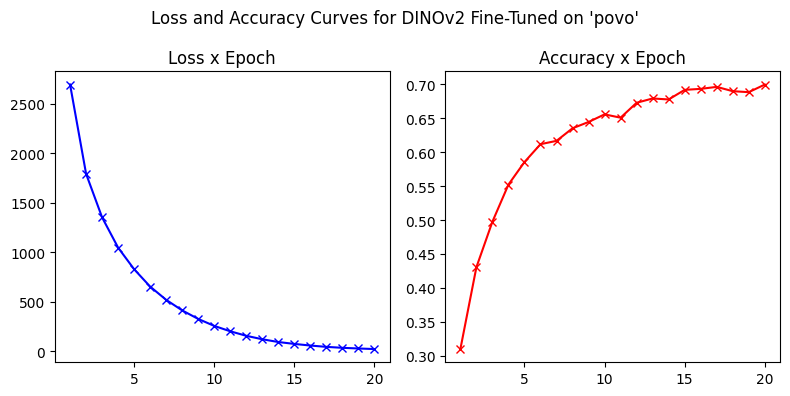

Validation accuracy: 0.69970703125
Validation average per class precision: 0.6649
Validation average per class recall: 0.6655

Test accuracy: 0.7369338274002075
Test average per class precision: 0.7391
Test average per class recall: 0.7107



Computing embeddings: 100%|███████████████████████████████████████| 705/705 [02:59<00:00,  3.93it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 10
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-6, weight_decay=3e-7)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

Training model:   5%|██▎                                          | 1/20 [05:00<1:35:10, 300.56s/it]

Best model saved at epoch 1
Epoch 1, Loss: 845.3803, Validation Accuracy: 0.6571


Training model:  10%|████▌                                        | 2/20 [10:10<1:31:45, 305.84s/it]

Best model saved at epoch 2
Epoch 2, Loss: 463.3907, Validation Accuracy: 0.7734


Training model:  15%|██████▊                                      | 3/20 [15:16<1:26:45, 306.20s/it]

Best model saved at epoch 3
Epoch 3, Loss: 339.7977, Validation Accuracy: 0.8108


Training model:  20%|█████████                                    | 4/20 [20:24<1:21:46, 306.68s/it]

Best model saved at epoch 4
Epoch 4, Loss: 264.0857, Validation Accuracy: 0.8365


Training model:  25%|███████████▎                                 | 5/20 [25:29<1:16:32, 306.18s/it]

Best model saved at epoch 5
Epoch 5, Loss: 207.6795, Validation Accuracy: 0.8483


Training model:  30%|█████████████▌                               | 6/20 [30:36<1:11:30, 306.46s/it]

Best model saved at epoch 6
Epoch 6, Loss: 162.7033, Validation Accuracy: 0.8542


Training model:  35%|███████████████▋                             | 7/20 [35:43<1:06:27, 306.71s/it]

Best model saved at epoch 7
Epoch 7, Loss: 124.7549, Validation Accuracy: 0.8631


Training model:  40%|██████████████████                           | 8/20 [40:49<1:01:17, 306.44s/it]

Best model saved at epoch 8
Epoch 8, Loss: 93.9868, Validation Accuracy: 0.8729


Training model:  45%|█████████████████████▏                         | 9/20 [45:50<55:51, 304.66s/it]

Best model saved at epoch 9
Epoch 9, Loss: 69.2734, Validation Accuracy: 0.8739


Training model:  50%|███████████████████████                       | 10/20 [50:50<50:33, 303.38s/it]

Best model saved at epoch 10
Epoch 10, Loss: 49.7868, Validation Accuracy: 0.8788


Training model:  55%|█████████████████████████▎                    | 11/20 [55:49<45:18, 302.09s/it]

Epoch 11, Loss: 35.5701, Validation Accuracy: 0.8749


Training model:  60%|██████████████████████████▍                 | 12/20 [1:00:49<40:10, 301.29s/it]

Epoch 12, Loss: 25.6106, Validation Accuracy: 0.8749


Training model:  65%|████████████████████████████▌               | 13/20 [1:05:48<35:05, 300.74s/it]

Epoch 13, Loss: 18.2196, Validation Accuracy: 0.8768


Training model:  70%|██████████████████████████████▊             | 14/20 [1:10:48<30:03, 300.54s/it]

Epoch 14, Loss: 13.3824, Validation Accuracy: 0.8768


Training model:  75%|█████████████████████████████████           | 15/20 [1:15:47<25:00, 300.02s/it]

Epoch 15, Loss: 9.7349, Validation Accuracy: 0.8788


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:20:48<20:00, 300.14s/it]

Best model saved at epoch 16
Epoch 16, Loss: 7.2167, Validation Accuracy: 0.8798


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:25:46<14:58, 299.64s/it]

Epoch 17, Loss: 5.6513, Validation Accuracy: 0.8729


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:30:45<09:59, 299.52s/it]

Epoch 18, Loss: 4.6028, Validation Accuracy: 0.8719


Training model:  95%|█████████████████████████████████████████▊  | 19/20 [1:35:46<04:59, 299.74s/it]

Best model saved at epoch 19
Epoch 19, Loss: 3.5024, Validation Accuracy: 0.8808


Training model: 100%|████████████████████████████████████████████| 20/20 [1:40:44<00:00, 302.20s/it]


Epoch 20, Loss: 3.3663, Validation Accuracy: 0.8788


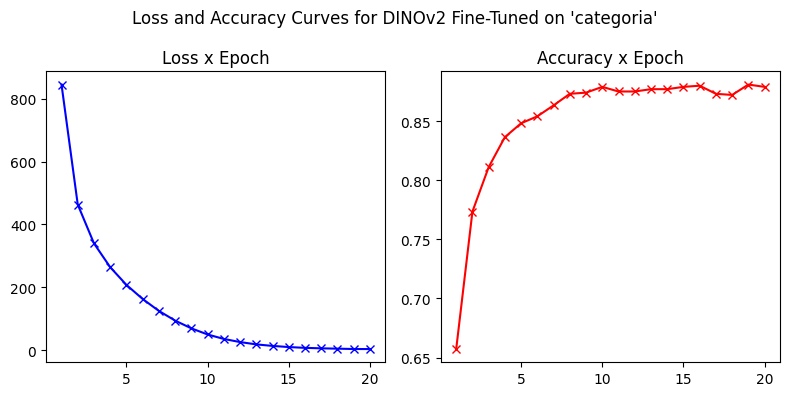

Validation accuracy: 0.880859375
Validation average per class precision: 0.8757
Validation average per class recall: 0.8395



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8757764101028442
Test average per class precision: 0.7710
Test average per class recall: 0.7606

Test average precision on filtered classes: 0.8566358354356554
Test average recall on filtered classes: 0.8451051579581367


In [40]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [41]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

Training model:   4%|█▊                                           | 1/25 [13:50<5:32:18, 830.76s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1782.2286, Validation Accuracy: 0.7718


Training model:   8%|███▌                                         | 2/25 [27:48<5:19:59, 834.75s/it]

Best model saved at epoch 2
Epoch 2, Loss: 865.2970, Validation Accuracy: 0.8188


Training model:  12%|█████▍                                       | 3/25 [42:12<5:11:02, 848.29s/it]

Best model saved at epoch 3
Epoch 3, Loss: 578.1605, Validation Accuracy: 0.8510


Training model:  16%|███████▏                                     | 4/25 [56:40<4:59:35, 855.97s/it]

Best model saved at epoch 4
Epoch 4, Loss: 404.0321, Validation Accuracy: 0.8620


Training model:  20%|████████▌                                  | 5/25 [1:11:04<4:46:15, 858.75s/it]

Best model saved at epoch 5
Epoch 5, Loss: 283.8990, Validation Accuracy: 0.8638


Training model:  24%|██████████▎                                | 6/25 [1:24:55<4:29:00, 849.49s/it]

Best model saved at epoch 6
Epoch 6, Loss: 202.1520, Validation Accuracy: 0.8767


Training model:  28%|████████████                               | 7/25 [1:38:44<4:12:47, 842.66s/it]

Best model saved at epoch 7
Epoch 7, Loss: 142.9941, Validation Accuracy: 0.8795


Training model:  32%|█████████████▊                             | 8/25 [1:52:32<3:57:26, 838.03s/it]

Best model saved at epoch 8
Epoch 8, Loss: 104.3125, Validation Accuracy: 0.8868


Training model:  36%|███████████████▍                           | 9/25 [2:06:15<3:42:11, 833.24s/it]

Epoch 9, Loss: 73.2125, Validation Accuracy: 0.8859


Training model:  40%|████████████████▊                         | 10/25 [2:19:56<3:27:23, 829.58s/it]

Best model saved at epoch 10
Epoch 10, Loss: 54.5135, Validation Accuracy: 0.8942


Training model:  44%|██████████████████▍                       | 11/25 [2:33:46<3:13:35, 829.66s/it]

Epoch 11, Loss: 42.9143, Validation Accuracy: 0.8868


Training model:  48%|████████████████████▏                     | 12/25 [2:47:28<2:59:14, 827.27s/it]

Epoch 12, Loss: 31.5075, Validation Accuracy: 0.8933


Training model:  52%|█████████████████████▊                    | 13/25 [3:01:11<2:45:13, 826.14s/it]

Epoch 13, Loss: 26.0408, Validation Accuracy: 0.8942


Training model:  56%|███████████████████████▌                  | 14/25 [3:14:56<2:31:24, 825.86s/it]

Best model saved at epoch 14
Epoch 14, Loss: 20.8878, Validation Accuracy: 0.8988


Training model:  60%|█████████████████████████▏                | 15/25 [3:28:42<2:17:38, 825.90s/it]

Epoch 15, Loss: 20.4658, Validation Accuracy: 0.8933


Training model:  64%|██████████████████████████▉               | 16/25 [3:42:24<2:03:42, 824.71s/it]

Epoch 16, Loss: 15.1071, Validation Accuracy: 0.8924


Training model:  68%|████████████████████████████▌             | 17/25 [3:56:06<1:49:50, 823.76s/it]

Epoch 17, Loss: 13.7056, Validation Accuracy: 0.8905


Training model:  72%|██████████████████████████████▏           | 18/25 [4:09:52<1:36:10, 824.35s/it]

Epoch 18, Loss: 12.3701, Validation Accuracy: 0.8924


Training model:  76%|███████████████████████████████▉          | 19/25 [4:23:38<1:22:29, 824.96s/it]

Epoch 19, Loss: 10.9899, Validation Accuracy: 0.8914


Training model:  80%|█████████████████████████████████▌        | 20/25 [4:37:22<1:08:43, 824.72s/it]

Best model saved at epoch 20
Epoch 20, Loss: 11.0530, Validation Accuracy: 0.8997


Training model:  84%|████████████████████████████████████▉       | 21/25 [4:51:13<55:05, 826.43s/it]

Best model saved at epoch 21
Epoch 21, Loss: 8.2663, Validation Accuracy: 0.9016


Training model:  88%|██████████████████████████████████████▋     | 22/25 [5:04:57<41:17, 825.81s/it]

Epoch 22, Loss: 8.3520, Validation Accuracy: 0.8988


Training model:  92%|████████████████████████████████████████▍   | 23/25 [5:18:37<27:28, 824.23s/it]

Epoch 23, Loss: 6.6849, Validation Accuracy: 0.9006


Training model:  96%|██████████████████████████████████████████▏ | 24/25 [5:32:26<13:45, 825.61s/it]

Epoch 24, Loss: 7.6782, Validation Accuracy: 0.9006


Training model: 100%|████████████████████████████████████████████| 25/25 [5:46:06<00:00, 830.67s/it]


Epoch 25, Loss: 5.6561, Validation Accuracy: 0.8942


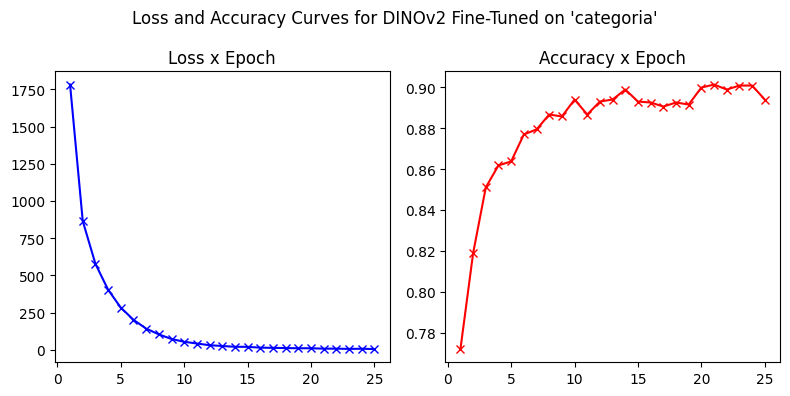

Validation accuracy: 0.9013671875
Validation average per class precision: 0.8777
Validation average per class recall: 0.8837



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.8987730145454407
Test average per class precision: 0.8732
Test average per class recall: 0.8744



In [42]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 25
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# _, _, \
# categoria_dino_umap, categoria_image_indices = \
# compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

Training model:   4%|█▊                                           | 1/25 [09:04<3:37:43, 544.30s/it]

Best model saved at epoch 1
Epoch 1, Loss: 2154.2197, Validation Accuracy: 0.6799


Training model:   8%|███▌                                         | 2/25 [18:05<3:27:57, 542.48s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1186.4308, Validation Accuracy: 0.7608


Training model:  12%|█████▍                                       | 3/25 [27:14<3:20:01, 545.53s/it]

Best model saved at epoch 3
Epoch 3, Loss: 923.2301, Validation Accuracy: 0.7930


Training model:  16%|███████▏                                     | 4/25 [36:23<3:11:24, 546.86s/it]

Best model saved at epoch 4
Epoch 4, Loss: 763.1520, Validation Accuracy: 0.8178


Training model:  20%|█████████                                    | 5/25 [45:31<3:02:25, 547.28s/it]

Best model saved at epoch 5
Epoch 5, Loss: 651.0706, Validation Accuracy: 0.8316


Training model:  24%|██████████▊                                  | 6/25 [54:33<2:52:45, 545.58s/it]

Best model saved at epoch 6
Epoch 6, Loss: 558.9509, Validation Accuracy: 0.8372


Training model:  28%|████████████                               | 7/25 [1:03:40<2:43:46, 545.92s/it]

Best model saved at epoch 7
Epoch 7, Loss: 484.2989, Validation Accuracy: 0.8510


Training model:  32%|█████████████▊                             | 8/25 [1:12:46<2:34:40, 545.92s/it]

Best model saved at epoch 8
Epoch 8, Loss: 420.1297, Validation Accuracy: 0.8565


Training model:  36%|███████████████▍                           | 9/25 [1:21:52<2:25:33, 545.83s/it]

Best model saved at epoch 9
Epoch 9, Loss: 366.8865, Validation Accuracy: 0.8703


Training model:  40%|████████████████▊                         | 10/25 [1:30:54<2:16:13, 544.90s/it]

Best model saved at epoch 10
Epoch 10, Loss: 318.7956, Validation Accuracy: 0.8740


Training model:  44%|██████████████████▍                       | 11/25 [1:40:00<2:07:10, 545.07s/it]

Best model saved at epoch 11
Epoch 11, Loss: 272.3617, Validation Accuracy: 0.8804


Training model:  48%|████████████████████▏                     | 12/25 [1:49:02<1:57:55, 544.26s/it]

Best model saved at epoch 12
Epoch 12, Loss: 238.9341, Validation Accuracy: 0.8841


Training model:  52%|█████████████████████▊                    | 13/25 [1:58:01<1:48:31, 542.62s/it]

Best model saved at epoch 13
Epoch 13, Loss: 207.3052, Validation Accuracy: 0.8868


Training model:  56%|███████████████████████▌                  | 14/25 [2:07:07<1:39:39, 543.61s/it]

Best model saved at epoch 14
Epoch 14, Loss: 179.1409, Validation Accuracy: 0.8896


Training model:  60%|█████████████████████████▏                | 15/25 [2:16:12<1:30:39, 543.97s/it]

Best model saved at epoch 15
Epoch 15, Loss: 154.8799, Validation Accuracy: 0.8905


Training model:  64%|██████████████████████████▉               | 16/25 [2:25:22<1:21:52, 545.81s/it]

Best model saved at epoch 16
Epoch 16, Loss: 132.5952, Validation Accuracy: 0.8970


Training model:  68%|████████████████████████████▌             | 17/25 [2:34:26<1:12:42, 545.28s/it]

Best model saved at epoch 17
Epoch 17, Loss: 114.4805, Validation Accuracy: 0.9016


Training model:  72%|██████████████████████████████▏           | 18/25 [2:43:37<1:03:49, 547.03s/it]

Epoch 18, Loss: 99.5358, Validation Accuracy: 0.9006


Training model:  76%|█████████████████████████████████▍          | 19/25 [2:52:51<54:55, 549.20s/it]

Best model saved at epoch 19
Epoch 19, Loss: 85.1039, Validation Accuracy: 0.9025


Training model:  80%|███████████████████████████████████▏        | 20/25 [3:02:00<45:44, 548.94s/it]

Best model saved at epoch 20
Epoch 20, Loss: 73.0013, Validation Accuracy: 0.9034


Training model:  84%|████████████████████████████████████▉       | 21/25 [3:11:13<36:40, 550.22s/it]

Best model saved at epoch 21
Epoch 21, Loss: 62.7142, Validation Accuracy: 0.9062


Training model:  88%|██████████████████████████████████████▋     | 22/25 [3:20:21<27:28, 549.55s/it]

Best model saved at epoch 22
Epoch 22, Loss: 52.8561, Validation Accuracy: 0.9080


Training model:  92%|████████████████████████████████████████▍   | 23/25 [3:29:26<18:16, 548.30s/it]

Best model saved at epoch 23
Epoch 23, Loss: 45.5065, Validation Accuracy: 0.9117


Training model:  96%|██████████████████████████████████████████▏ | 24/25 [3:38:29<09:06, 546.64s/it]

Best model saved at epoch 24
Epoch 24, Loss: 39.8397, Validation Accuracy: 0.9135


Training model: 100%|████████████████████████████████████████████| 25/25 [3:47:39<00:00, 546.37s/it]


Epoch 25, Loss: 33.9960, Validation Accuracy: 0.9126


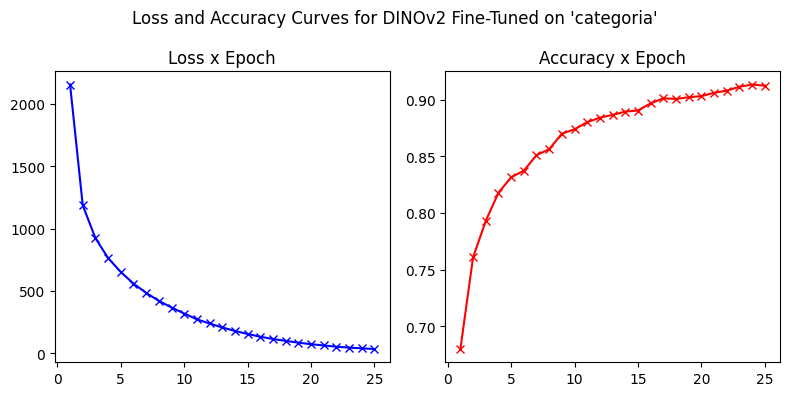

Validation accuracy: 0.91357421875
Validation average per class precision: 0.8910
Validation average per class recall: 0.8969

Test accuracy: 0.8987730145454407
Test average per class precision: 0.8735
Test average per class recall: 0.8830



Computing embeddings: 100%|█████████████████████████████████████| 1410/1410 [02:56<00:00,  7.99it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 25
num_classes = len(categoria_filtered_categories)
freeze = 10
model = DINOClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [44]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [45]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

Training model:   4%|█▊                                           | 1/25 [08:46<3:30:29, 526.23s/it]

Best model saved at epoch 1
Epoch 1, Combined Loss: 3397.9489, Validation Average Accuracy: 0.4858


Training model:   8%|███▌                                         | 2/25 [17:23<3:19:47, 521.20s/it]

Best model saved at epoch 2
Epoch 2, Combined Loss: 2258.6273, Validation Average Accuracy: 0.5835


Training model:  12%|█████▍                                       | 3/25 [25:59<3:10:09, 518.61s/it]

Best model saved at epoch 3
Epoch 3, Combined Loss: 1788.1918, Validation Average Accuracy: 0.6489


Training model:  16%|███████▏                                     | 4/25 [34:31<3:00:35, 515.98s/it]

Best model saved at epoch 4
Epoch 4, Combined Loss: 1461.4919, Validation Average Accuracy: 0.6777


Training model:  20%|█████████                                    | 5/25 [43:07<2:51:59, 515.96s/it]

Best model saved at epoch 5
Epoch 5, Combined Loss: 1210.1109, Validation Average Accuracy: 0.7021


Training model:  24%|██████████▊                                  | 6/25 [51:36<2:42:38, 513.59s/it]

Best model saved at epoch 6
Epoch 6, Combined Loss: 1009.9879, Validation Average Accuracy: 0.7129


Training model:  28%|████████████                               | 7/25 [1:00:06<2:33:44, 512.50s/it]

Best model saved at epoch 7
Epoch 7, Combined Loss: 847.3584, Validation Average Accuracy: 0.7241


Training model:  32%|█████████████▊                             | 8/25 [1:08:36<2:25:00, 511.82s/it]

Best model saved at epoch 8
Epoch 8, Combined Loss: 713.5364, Validation Average Accuracy: 0.7397


Training model:  36%|███████████████▍                           | 9/25 [1:17:08<2:16:29, 511.87s/it]

Best model saved at epoch 9
Epoch 9, Combined Loss: 603.3708, Validation Average Accuracy: 0.7461


Training model:  40%|████████████████▊                         | 10/25 [1:25:43<2:08:10, 512.70s/it]

Best model saved at epoch 10
Epoch 10, Combined Loss: 510.4729, Validation Average Accuracy: 0.7559


Training model:  44%|██████████████████▍                       | 11/25 [1:34:21<2:00:00, 514.31s/it]

Best model saved at epoch 11
Epoch 11, Combined Loss: 429.3540, Validation Average Accuracy: 0.7568


Training model:  48%|████████████████████▏                     | 12/25 [1:42:57<1:51:31, 514.77s/it]

Best model saved at epoch 12
Epoch 12, Combined Loss: 360.3947, Validation Average Accuracy: 0.7803


Training model:  52%|█████████████████████▊                    | 13/25 [1:51:22<1:42:22, 511.84s/it]

Epoch 13, Combined Loss: 301.3911, Validation Average Accuracy: 0.7666


Training model:  56%|███████████████████████▌                  | 14/25 [1:59:46<1:33:23, 509.39s/it]

Epoch 14, Combined Loss: 250.2973, Validation Average Accuracy: 0.7769


Training model:  60%|█████████████████████████▏                | 15/25 [2:08:20<1:25:08, 510.82s/it]

Epoch 15, Combined Loss: 207.3323, Validation Average Accuracy: 0.7773


Training model:  64%|██████████████████████████▉               | 16/25 [2:16:47<1:16:29, 509.90s/it]

Best model saved at epoch 16
Epoch 16, Combined Loss: 174.9455, Validation Average Accuracy: 0.7822


Training model:  68%|████████████████████████████▌             | 17/25 [2:25:24<1:08:14, 511.83s/it]

Best model saved at epoch 17
Epoch 17, Combined Loss: 144.8491, Validation Average Accuracy: 0.7910


Training model:  72%|██████████████████████████████▏           | 18/25 [2:34:04<1:00:01, 514.46s/it]

Best model saved at epoch 18
Epoch 18, Combined Loss: 120.8890, Validation Average Accuracy: 0.7920


Training model:  76%|█████████████████████████████████▍          | 19/25 [2:43:08<52:19, 523.21s/it]

Best model saved at epoch 19
Epoch 19, Combined Loss: 102.0484, Validation Average Accuracy: 0.7988


Training model:  80%|███████████████████████████████████▏        | 20/25 [2:52:04<43:55, 527.08s/it]

Epoch 20, Combined Loss: 84.5928, Validation Average Accuracy: 0.7988


Training model:  84%|████████████████████████████████████▉       | 21/25 [3:00:57<35:15, 528.87s/it]

Best model saved at epoch 21
Epoch 21, Combined Loss: 73.9463, Validation Average Accuracy: 0.8003


Training model:  88%|██████████████████████████████████████▋     | 22/25 [3:09:56<26:35, 531.79s/it]

Epoch 22, Combined Loss: 63.6619, Validation Average Accuracy: 0.7988


Training model:  92%|████████████████████████████████████████▍   | 23/25 [3:18:50<17:45, 532.59s/it]

Best model saved at epoch 23
Epoch 23, Combined Loss: 52.8104, Validation Average Accuracy: 0.8027


Training model:  96%|██████████████████████████████████████████▏ | 24/25 [3:27:53<08:55, 535.67s/it]

Epoch 24, Combined Loss: 46.1300, Validation Average Accuracy: 0.8003


Training model: 100%|████████████████████████████████████████████| 25/25 [3:37:25<00:00, 521.82s/it]


Epoch 25, Combined Loss: 39.0561, Validation Average Accuracy: 0.8018


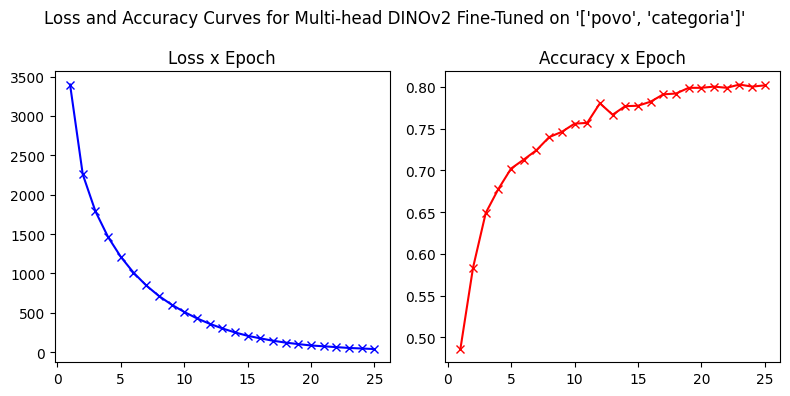

Validation 'povo' head accuracy: 0.705078125
Validation 'categoria' head accuracy: 0.900390625
Validation average accuracy: 0.802734375

Validation 'povo' head average per class precision: 0.6509
Validation 'povo' head average per class recall: 0.6652

Validation 'categoria' head average per class precision: 0.8752
Validation 'categoria' head average per class recall: 0.8378



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:719: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test 'povo' head accuracy: 0.725043773651123
Test 'categoria' head accuracy: 0.9124343395233154
Test average accuracy: 0.81884765625

Test 'povo' head average per class precision: 0.7226
Test 'povo' head average per class recall: 0.7011

Test 'categoria' head average per class precision: 0.8762
Test 'categoria' head average per class recall: 0.8825



Computing embeddings: 100%|█████████████████████████████████████| 1410/1410 [03:29<00:00,  6.72it/s]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [46]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 25
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-7, weight_decay=1e-7)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.3, 0.7]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

_, _, multihead_dino_umap, \
multihead_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device, \
                                                        'dino')

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [47]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

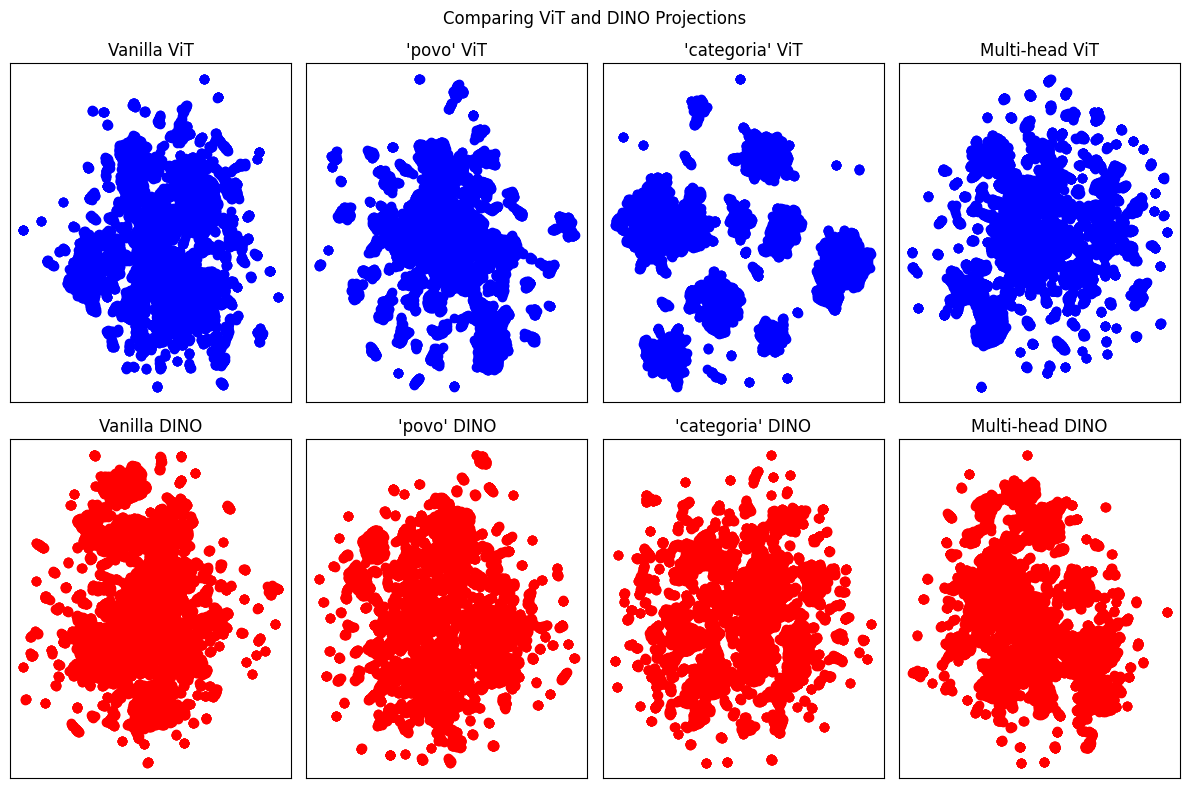

In [48]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap, multihead_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT", "Multi-head ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 4)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap, multihead_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO", "Multi-head DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 4)

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:818: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


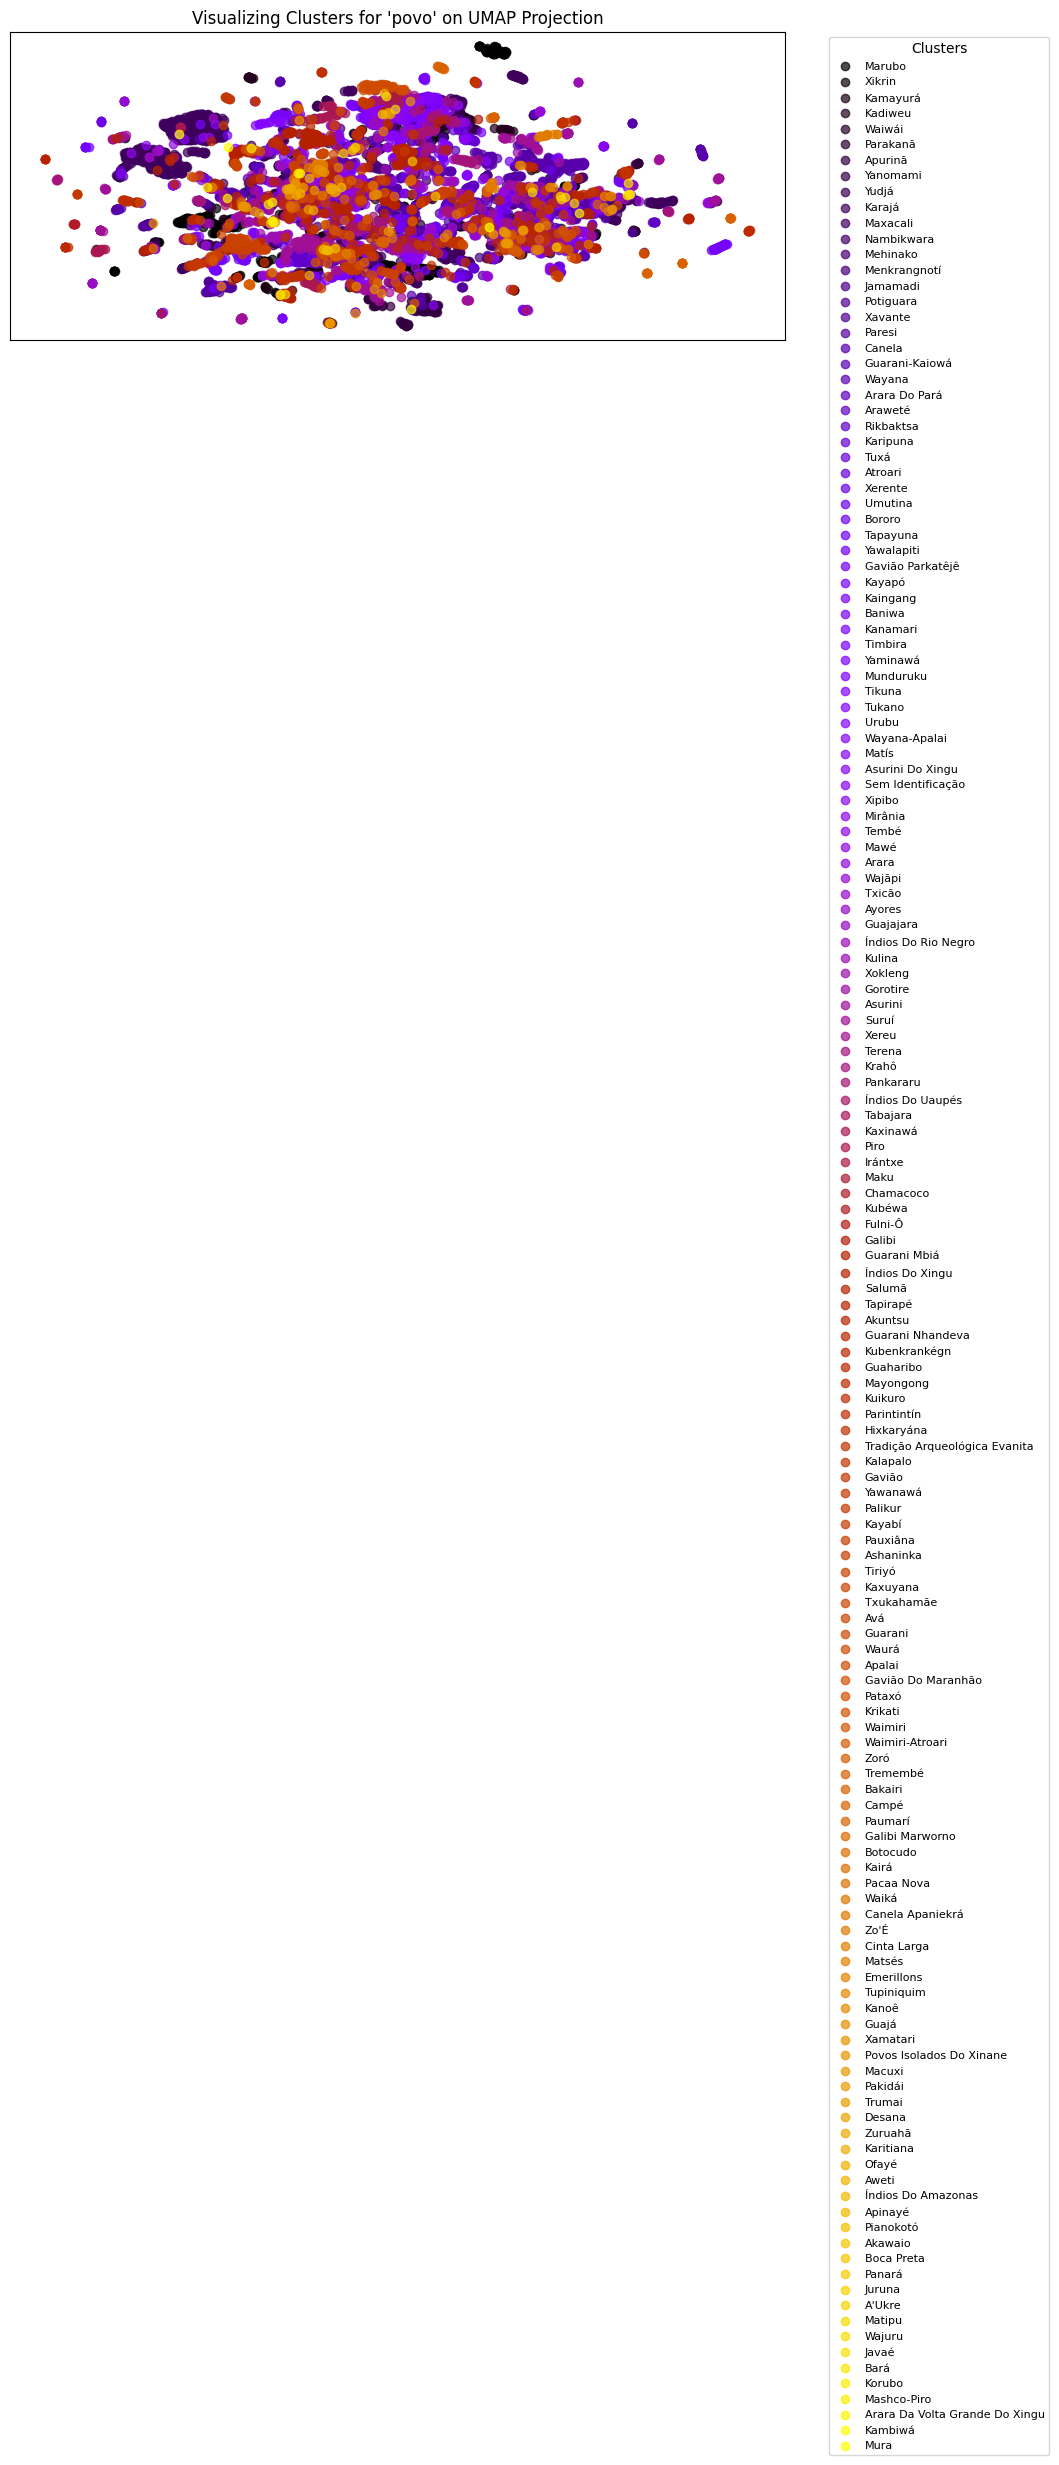

In [49]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_dino_umap, povo_image_indices, 'povo', 'UMAP')

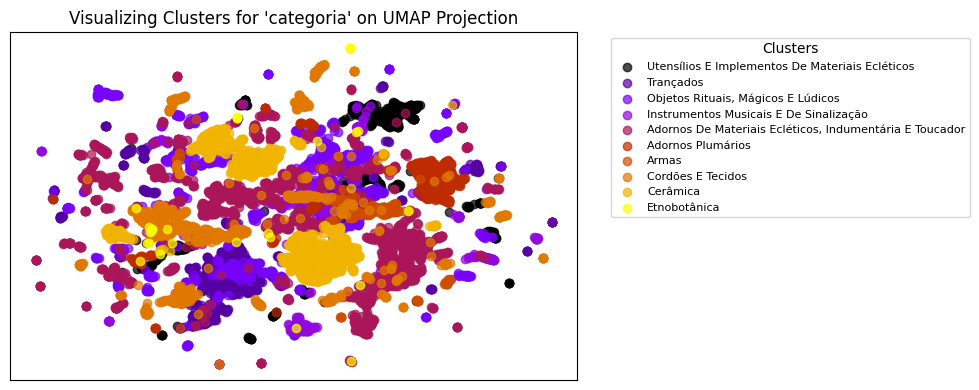

In [50]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_dino_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

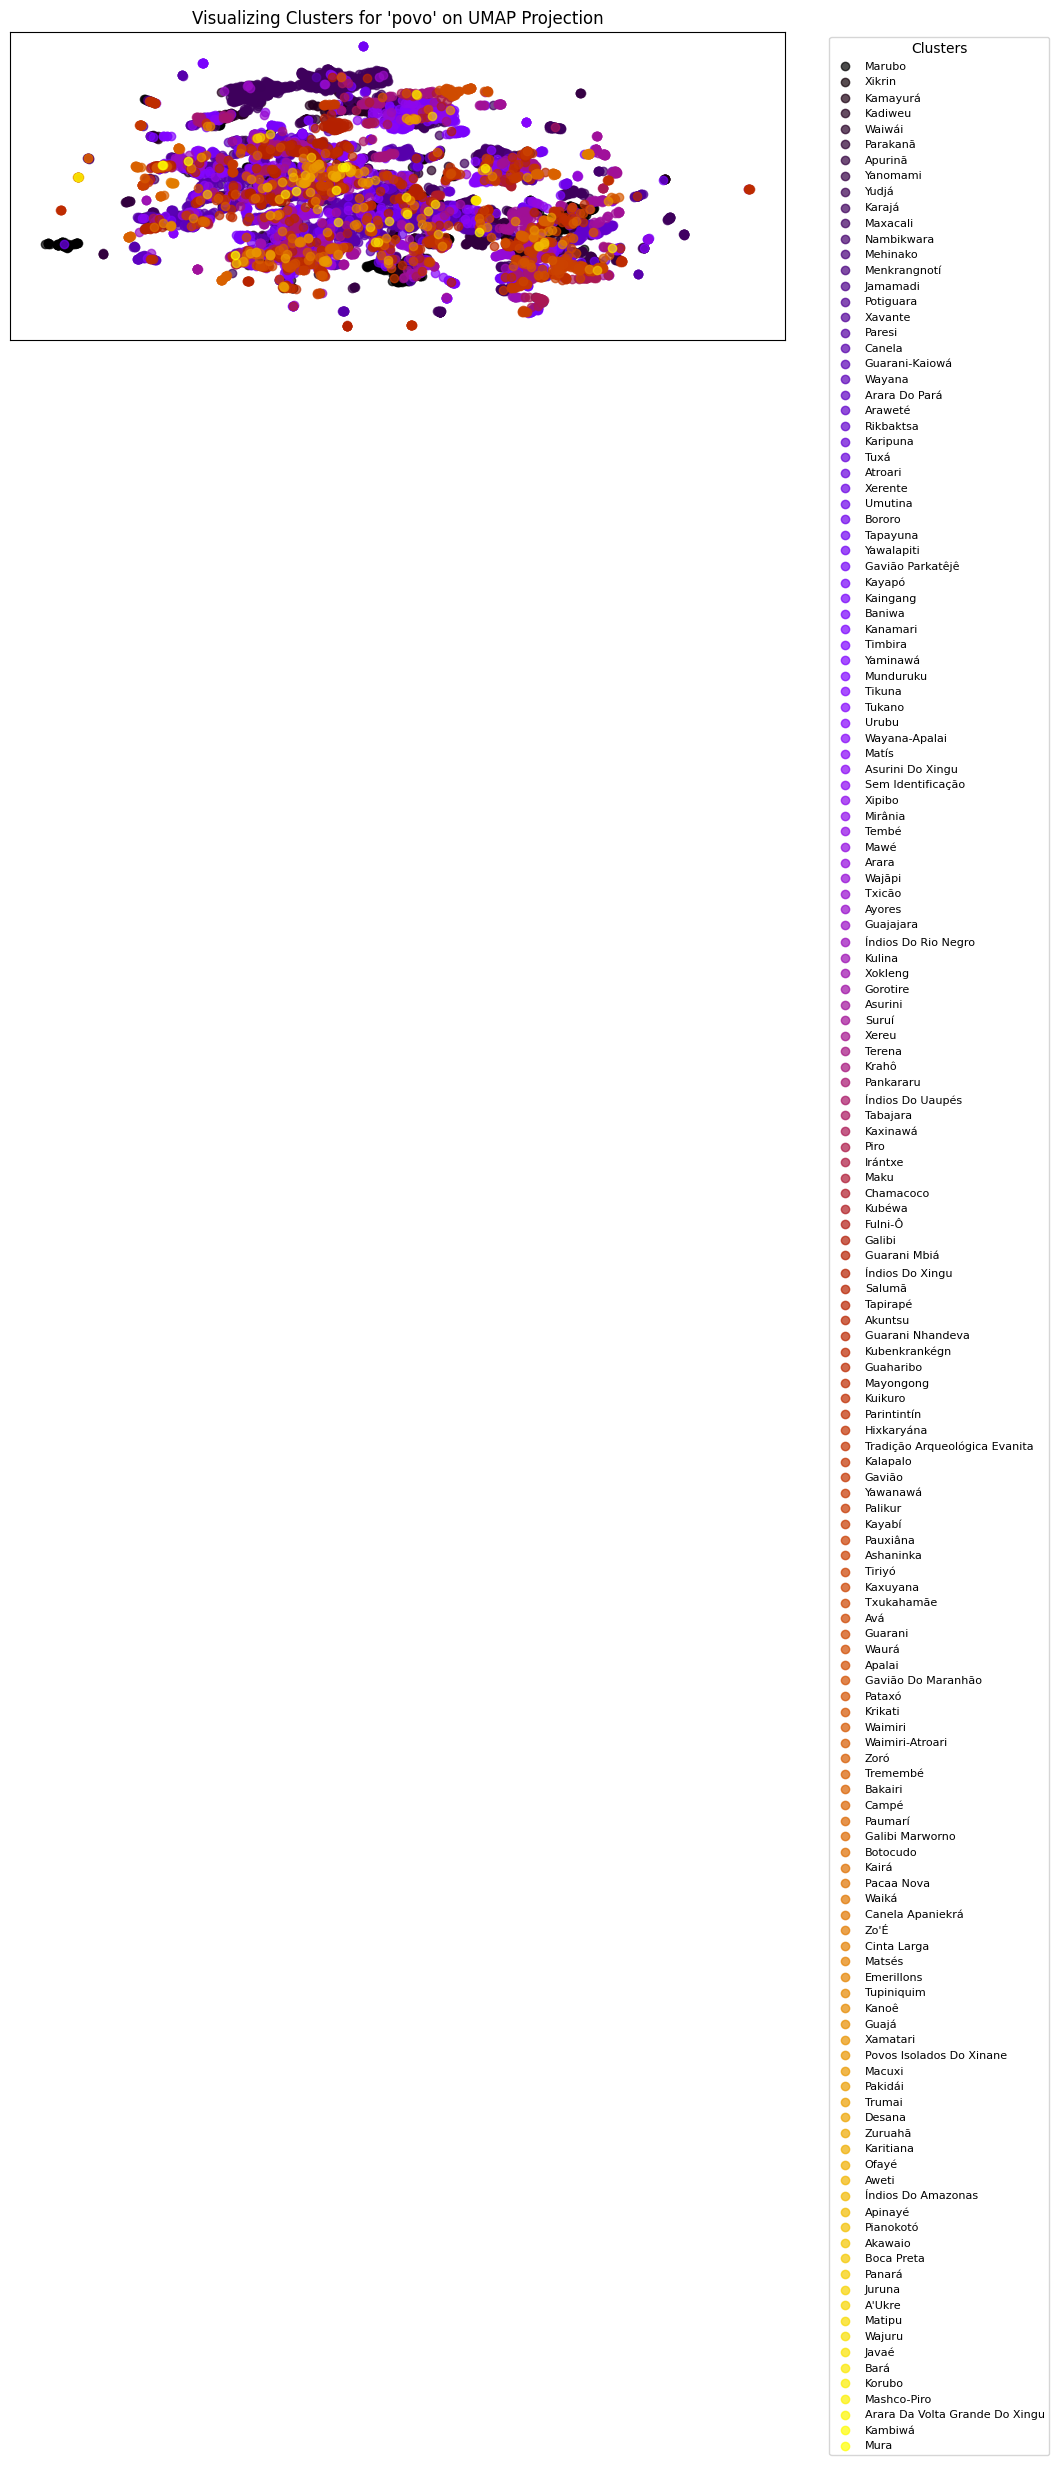

In [51]:
# Visualizing 'povo' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'povo', 'UMAP')

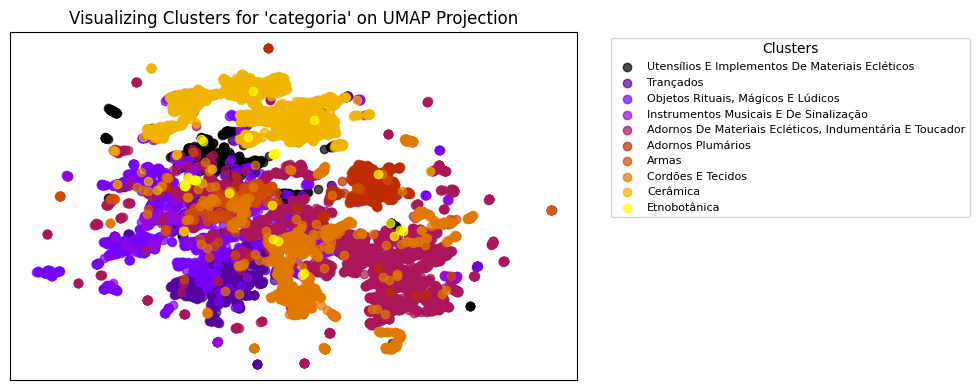

In [52]:
# Visualizing 'categoria' cluster for multi-head modedl
visualizing_clusters(filtered_df, multihead_dino_umap, multihead_image_indices, \
                     'categoria', 'UMAP')

In [53]:
# Saving outputs for visualization tool
# _ = saving_outputs(filtered_df, povo_labels, vanilla_dino_umap, vanilla_image_indices, \
#                    save_file='vanilla_dino.csv', no_clusters=True)

# _ = saving_outputs(filtered_df, povo_labels, povo_dino_umap, povo_image_indices, 'povo', \
#                    'povo_dino.csv')

# _ = saving_outputs(filtered_df, categoria_labels, categoria_dino_umap, \
#                    categoria_image_indices, 'categoria', 'categoria_dino.csv')

# _ = saving_outputs(filtered_df, povo_labels, multihead_dino_umap, \
#                    multihead_image_indices, save_file='multihead_dino.csv', no_clusters=True)